# Importing libraries and loading data

In [1]:
!pip install -q feature_engine

In [2]:
%pip install shap
%pip install catboost

# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings 
warnings.filterwarnings("ignore")

import shap
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from feature_engine.encoding import RareLabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import re

pd.set_option('display.max_rows', 1000)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
df = pd.read_csv('unicorn_startup_companies.csv').drop(['Unnamed: 0'], axis=1).drop_duplicates()
print(df.shape)
df.sample(5).T

(1221, 7)


,771,927,806,169,693
Company,LinkTree,Mixpanel,Kallyope,Lenskart,SonderMind
Valuation ($B),$1.30,$1.05,$1.22,$4.50,$1.42
Date Joined,3/16/2022,11/15/2021,2/15/2022,12/20/2019,7/28/2021
Country,Australia,United States,United States,India,United States
City,Melbourne,San Francisco,New York,Faridabad,Denver
Industry,Media & Entertainment,Enterprise Tech,Healthcare & Life Sciences,Consumer & Retail,Healthcare & Life Sciences
Select Investors,"AirTree Ventures, Insight Partners, Index Vent...","Bain Capital Tech Opportunities, Andreessen Ho...","The Column Group, Alexandria Venture Investmen...","Chiratae Ventures, PremjiInvest, Softbank","Kickstart Fund, General Catalyst, Drive Capital"


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1221 entries, 0 to 1220
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Company           1221 non-null   object
 1   Valuation ($B)    1221 non-null   object
 2   Date Joined       1221 non-null   object
 3   Country           1221 non-null   object
 4   City              1203 non-null   object
 5   Industry          1221 non-null   object
 6   Select Investors  1219 non-null   object
dtypes: object(7)
memory usage: 66.9+ KB


In [ ]:
df.describe().T

,count,unique,top,freq
Company,1221,1216,Fabric,2
Valuation ($B),1221,226,$1,278
Date Joined,1221,735,7/13/2021,8
Country,1221,51,United States,656
City,1203,289,San Francisco,171
Industry,1221,7,Enterprise Tech,370
Select Investors,1219,1200,Sequoia Capital,3


In [7]:
df.columns

Index(['Company', 'Valuation ($B)', 'Date Joined', 'Country', 'City',
       'Industry', 'Select Investors'],
      dtype='object')

# Data transformation

In [8]:
# rename columns by stripping spaces
df.rename(columns={key:key.lstrip(' ').split('(')[0] for key in df.columns}, inplace=True)
# select and log10-transform main label
main_label = 'log10_Valuation'
df[main_label] = df['Valuation '].apply(lambda x: np.log10(float(str(x).replace('$', ''))))
# exclude the high-end tail of unicorns
df = df[df[main_label]<=1.3]
# extract year from Date Joined
df['Date Joined'] = df['Date Joined'].apply(lambda x: x[-4:])
# replace some of the duplicate values
df['Industry'] = df['Industry'].str.replace('&amp;', 'and', regex=True)
df['Select Investors'] = df['Select Investors'].str.replace('Sequoia Capital China', 'Sequoia Capital', regex=True)
df['Select Investors'] = df['Select Investors'].str.replace('Sequoia Capital India', 'Sequoia Capital', regex=True)
# vectorize columns
def vectorize_column(df, col_name, sep=', ', min_df=20):
    ll = df[col_name].fillna('none').str.split(sep).to_list()
    ll = [[j.rstrip(', ').strip(' ').replace(' / ', '_').replace('.', '_').replace('\'', '_').replace(' ', '_').replace('.', '_').replace('&amp;', '_').replace('&', '_').replace('-', '_').strip('_') for j in i] for i in ll]
    ll1 = []
    for item in ll:
        if item != ['none']:
            ttt = ' '.join(item)
        else:
            ttt = 'none'
        ll1.append(ttt)
    vectorizer = CountVectorizer(min_df=min_df, lowercase=False)
    vectorizer.fit(ll1)
    voc = vectorizer.vocabulary_
    voc_inv = {v: col_name+'_'+k for k, v in voc.items()}
    vector = vectorizer.transform(ll1)
    tt = pd.DataFrame(vector.toarray())
    tt = tt.rename(columns=voc_inv)
    df = pd.concat([df.reset_index(drop=True),tt.reset_index(drop=True)], axis=1).drop([col_name], axis=1)
    return df
for col in ['Select Investors']:
    df = vectorize_column(df, col_name=col, sep=', ', min_df=20)
# combine city and country
df['City'] = df['City'] + ', ' + df['Country']
# set up the rare label encoder limiting number of categories to max_n_categories
for col in ['City', 'Industry']:
    df[col] = df[col].fillna('None')
    encoder = RareLabelEncoder(n_categories=1, max_n_categories=50, replace_with='Other', tol=20.0/df.shape[0])
    df[col] = encoder.fit_transform(df[[col]])
# finally, drop unused columns
cols2drop = ['Country', 'Company', 'Valuation ']
df = df.drop(cols2drop, axis=1)
print(df.shape)
df.sample(5).T

(1208, 23)


,285,884,1019,381,652
Date Joined,2016,2021,2020,2020,2022
City,Other,"New York, United States","London, United Kingdom","Shanghai, China",Other
Industry,Consumer & Retail,Consumer & Retail,Consumer & Retail,Enterprise Tech,Enterprise Tech
log10_Valuation,0.477121,0.041393,0.230449,0.365488,0.176091
Select Investors_Accel,0,0,0,0,1
Select Investors_Andreessen_Horowitz,0,0,0,0,0
Select Investors_Bessemer_Venture_Partners,0,0,0,0,0
Select Investors_Coatue_Management,0,0,0,0,0
Select Investors_General_Atlantic,0,0,0,0,0
Select Investors_General_Catalyst,0,0,0,0,0


# Machine learning

In [9]:
# initialize data
y = df[main_label].values.reshape(-1,)
X = df.drop([main_label], axis=1)
cat_cols = X.select_dtypes(include=['object']).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=83)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((604, 22), (604, 22), (604,), (604,))

In [ ]:
# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_cols_idx)
test_pool = Pool(X_test,
                 y_test,
                 cat_features=cat_cols_idx)
# specify the training parameters 
model = CatBoostRegressor(iterations=500,
                          depth=5,
                          learning_rate=0.02,
                          verbose=0,
                          loss_function='RMSE')
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE score for train {round(rmse_train,3)} dex, and for test {round(rmse_test,3)} dex")

RMSE score for train 0.253 dex, and for test 0.268 dex


In [12]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_train, [np.mean(y_train)]*len(y_train))
rmse_bs_train = np.sqrt(mse)


In [14]:
# Install required packages (run this cell separately if you get errors)
%pip install shap catboost feature_engine

Note: you may need to restart the kernel to use updated packages.


In [15]:
# Baseline scores (assuming the same prediction for all data samples)
rmse_bs_train = np.sqrt(mean_squared_error(y_train, [np.mean(y_train)]*len(y_train)))
rmse_bs_test = np.sqrt(mean_squared_error(y_test, [np.mean(y_train)]*len(y_test)))
print(f"RMSE baseline score for train {round(rmse_bs_train,3)} dex, and for test {round(rmse_bs_test,3)} dex")

RMSE baseline score for train 0.295 dex, and for test 0.29 dex


# Explanations with SHAP values

In [22]:
import pandas as pd

# Convert categorical variables to dummy/indicator variables
X_encoded = pd.get_dummies(X)

# Now split and train
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


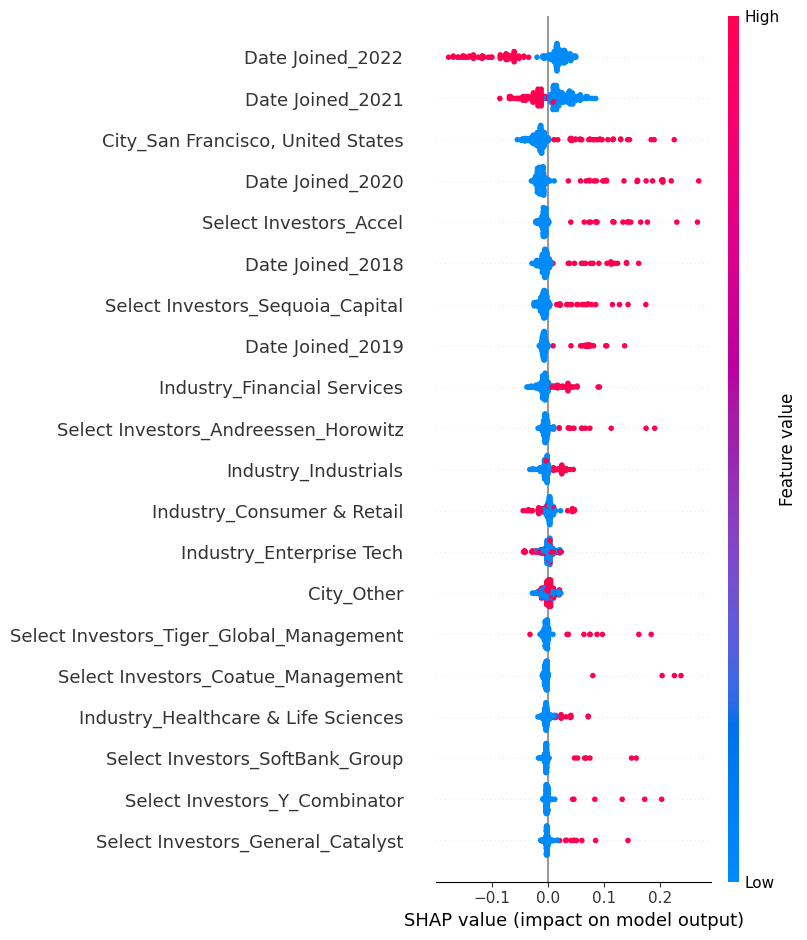

In [23]:
import shap

# Initialize JavaScript visualizations
shap.initjs()

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


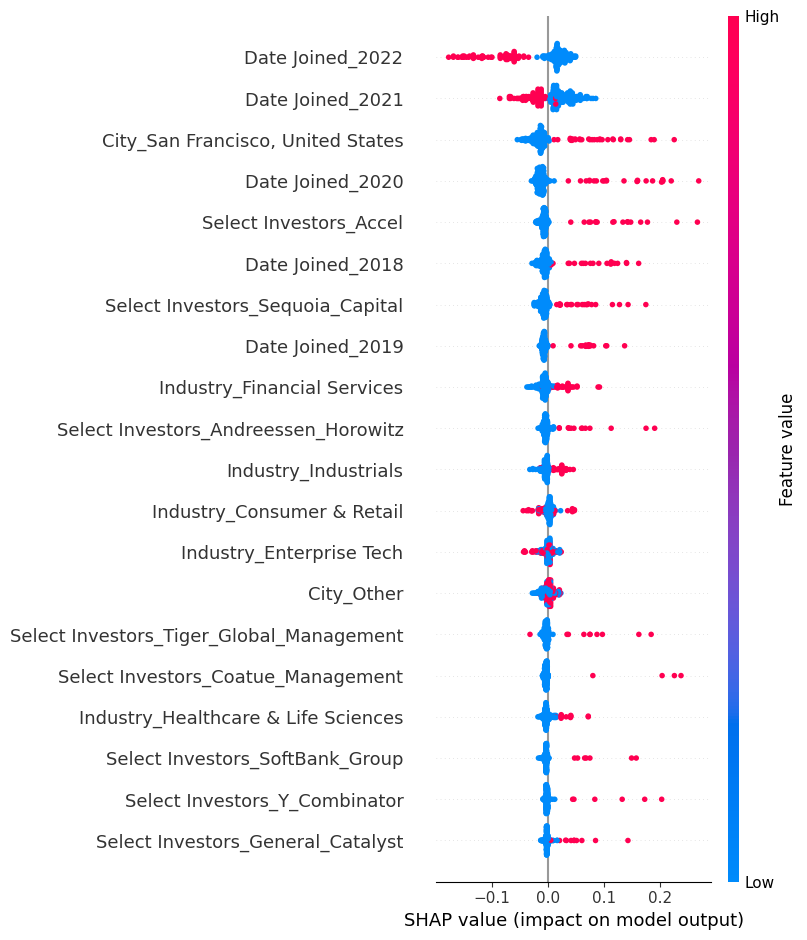

In [24]:
assert 'model' in globals(), "You must run the cell that defines 'model' first."
shap.initjs()
ex = shap.TreeExplainer(model)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [26]:
expected_values = ex.expected_value
avg_pred_val = float(expected_values) if np.isscalar(expected_values) else float(expected_values[0])
print(f"Average predicted valuation is {round(10**avg_pred_val,3)} bln USD")
print(f"Average actual valuation is {round(10**np.mean(y_test),3)} bln USD")

Average predicted valuation is 1.928 bln USD
Average actual valuation is 1.961 bln USD


In [27]:
def show_shap0(col):
    df_infl = X_test.copy()
    df_infl['shap_'] = shap_values[:,X_test.columns.tolist().index(col)]
    gain = 0
    gain = df_infl.groupby(col).mean().loc[1, 'shap_']-df_infl.groupby(col).mean().loc[0, 'shap_']
    gain_std = ((df_infl.groupby(col).std().loc[1, 'shap_'])**2+(df_infl.groupby(col).std().loc[0, 'shap_'])**2)**0.5
    return round(gain,4), round(gain_std,4)
def show_variants(start_str, label):
    col_list = []
    gain_list = []
    gain_std_list = []
    for col in X_test.columns:
        if col.startswith(start_str+'_'):
            try:
                gain, gain_std = show_shap0(col)
                col_list.append(col.replace(start_str+'_',''))
                gain_list.append(gain)
                gain_std_list.append(gain_std)
            except:
                pass
    dd_dict = {'col': col_list, 'gain': gain_list, 'gain_std': gain_std_list}
    df_res = pd.DataFrame.from_dict(dd_dict).sort_values('gain', ascending=False).set_index('col')
    plt.figure(figsize=(12,8))
    plt.errorbar(df_res.index, df_res['gain'], yerr=df_res['gain_std'], fmt="o", color="r")
    plt.bar(x=df_res.index, height=df_res['gain'])
    plt.title(f'SHAP values for {start_str}, label {label}')
    plt.ylabel('dex')
    plt.tick_params(axis="x", rotation=90)
    plt.show();
    return df_res

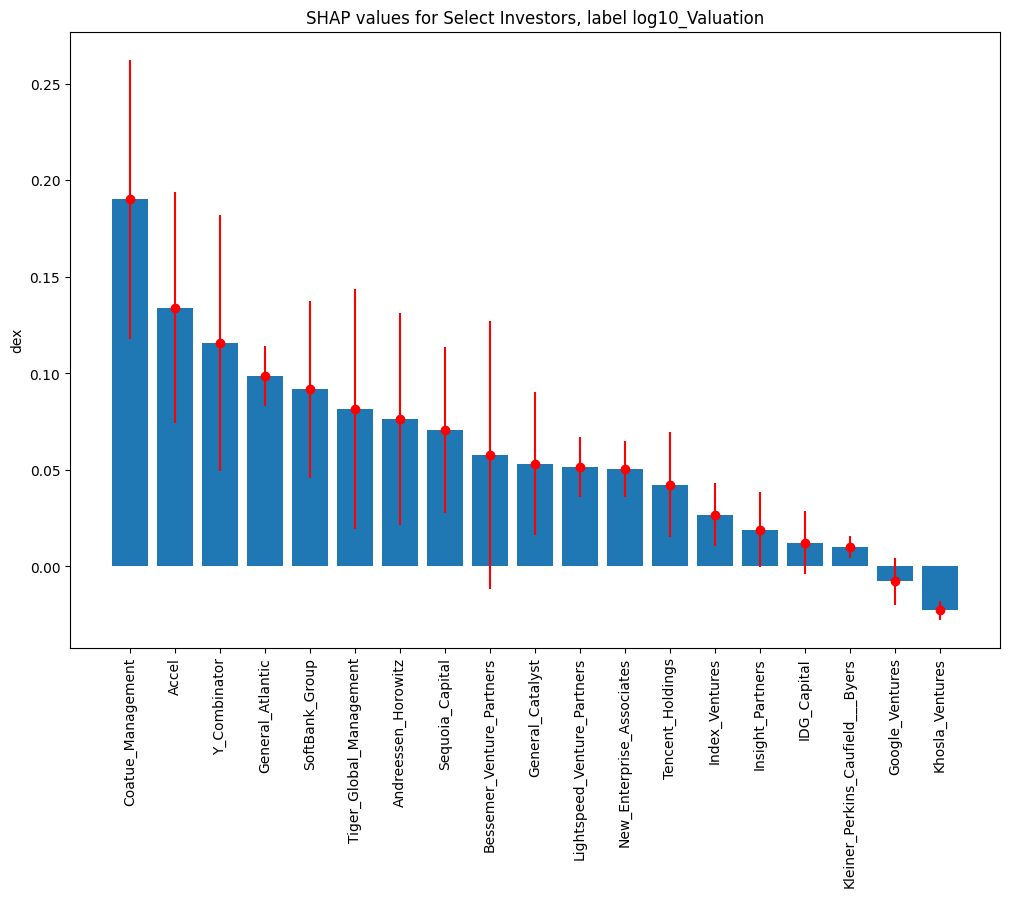

,gain,gain_std
col,,
Coatue_Management,0.1902,0.0723
Accel,0.1339,0.0598
Y_Combinator,0.1156,0.0664
General_Atlantic,0.0986,0.0157
SoftBank_Group,0.0916,0.0457
Tiger_Global_Management,0.0814,0.0621
Andreessen_Horowitz,0.0764,0.0549
Sequoia_Capital,0.0705,0.0431
Bessemer_Venture_Partners,0.0575,0.0695


In [28]:
show_variants(start_str='Select Investors', label=main_label)


Date Joined_2007



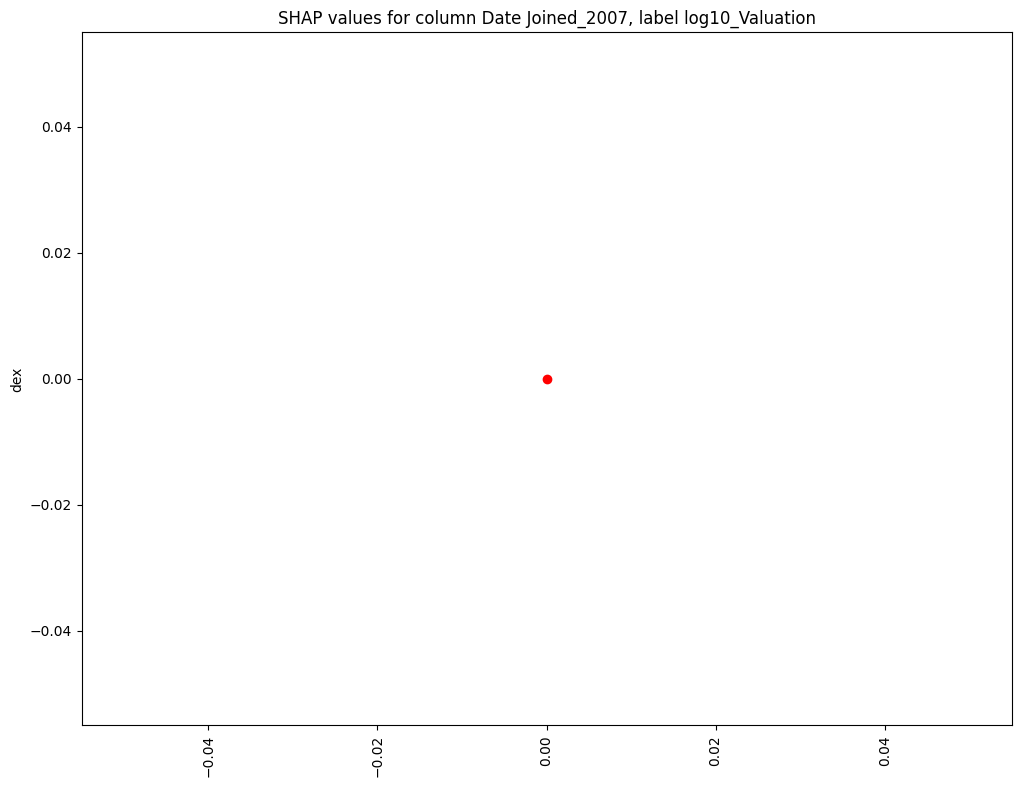

       gain  gain_std  count
col                         
False   0.0       0.0    242

Date Joined_2011



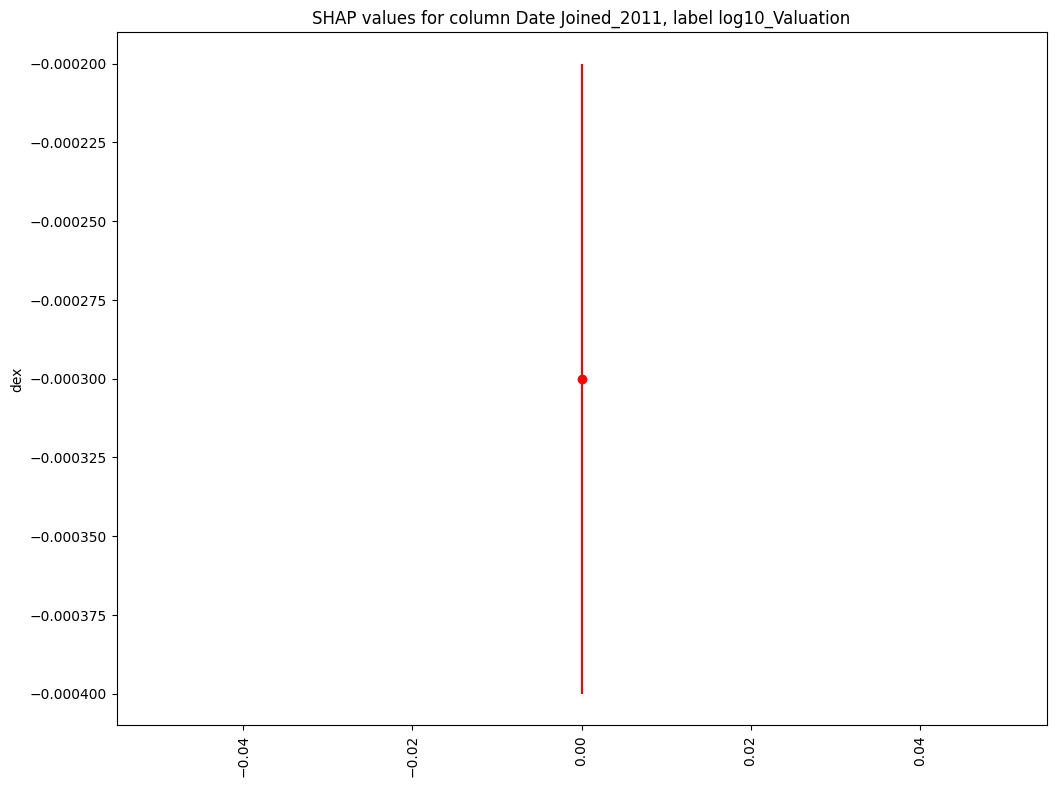

         gain  gain_std  count
col                           
False -0.0003    0.0001    242

Date Joined_2012



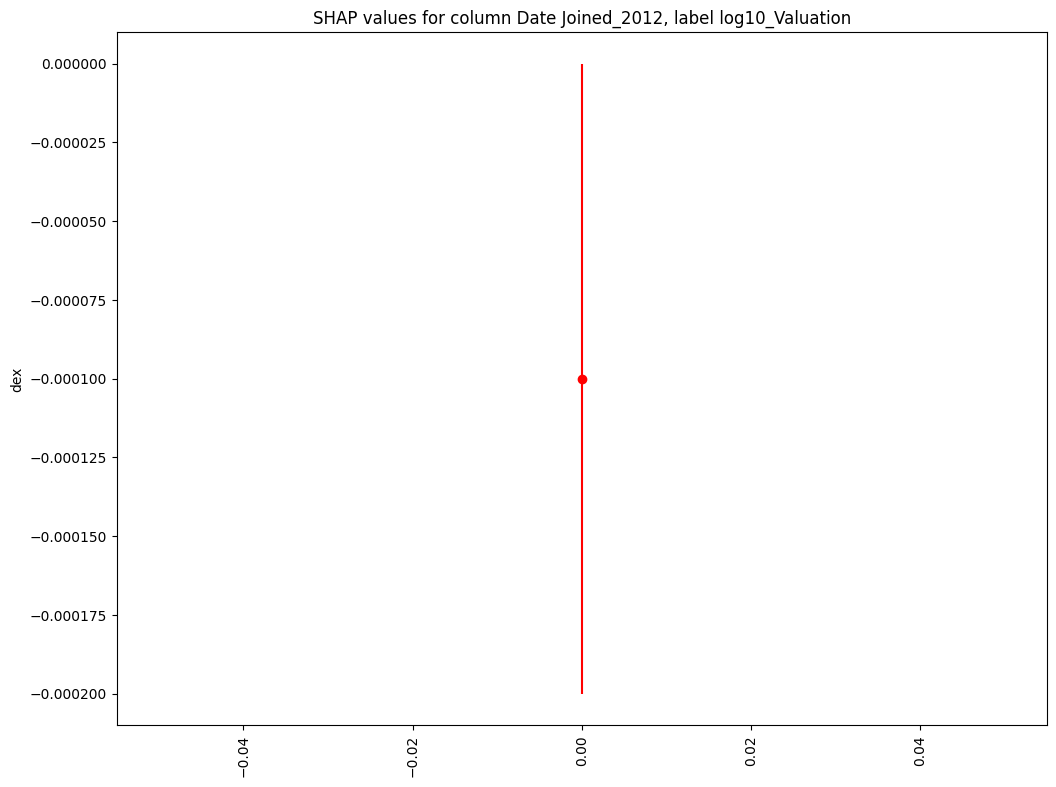

         gain  gain_std  count
col                           
False -0.0001    0.0001    242

Date Joined_2013



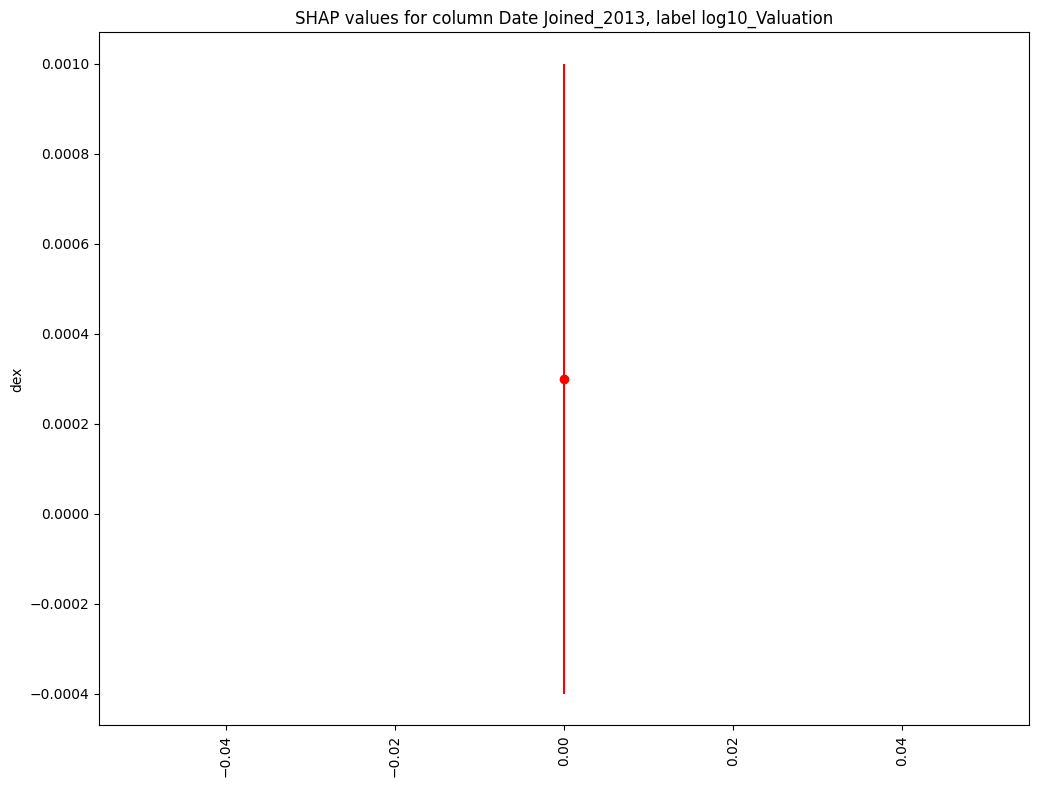

         gain  gain_std  count
col                           
False  0.0003    0.0007    242

Date Joined_2014



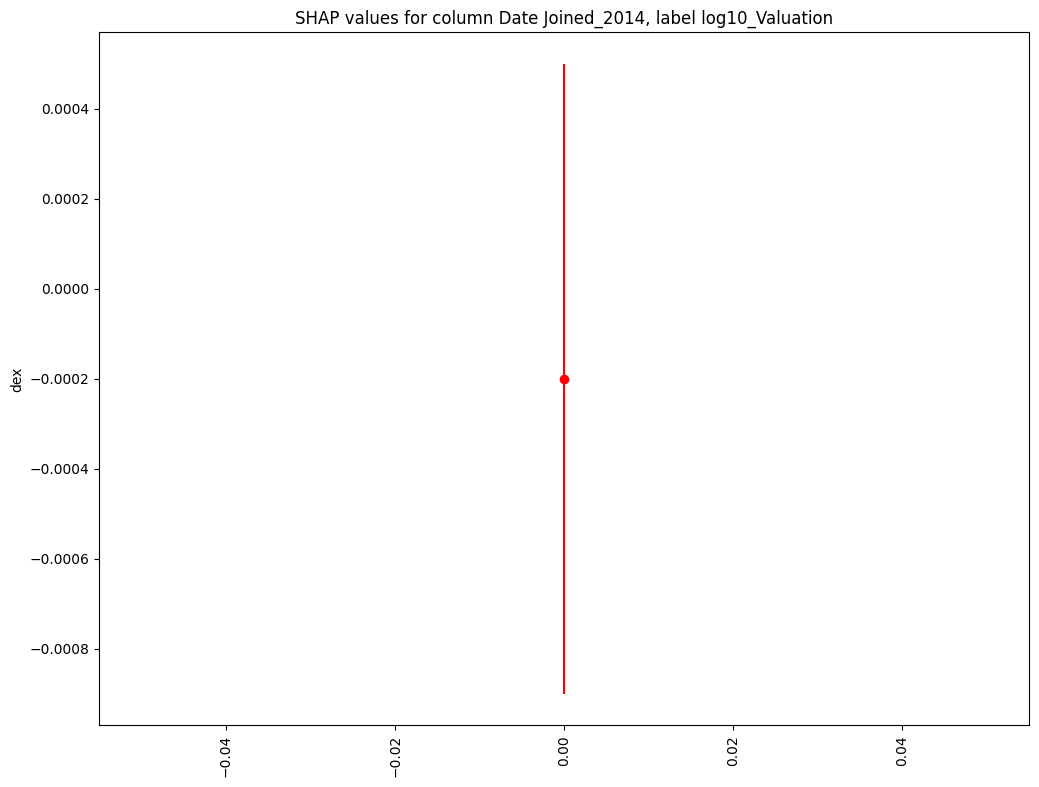

         gain  gain_std  count
col                           
False -0.0002    0.0007    242

Date Joined_2015



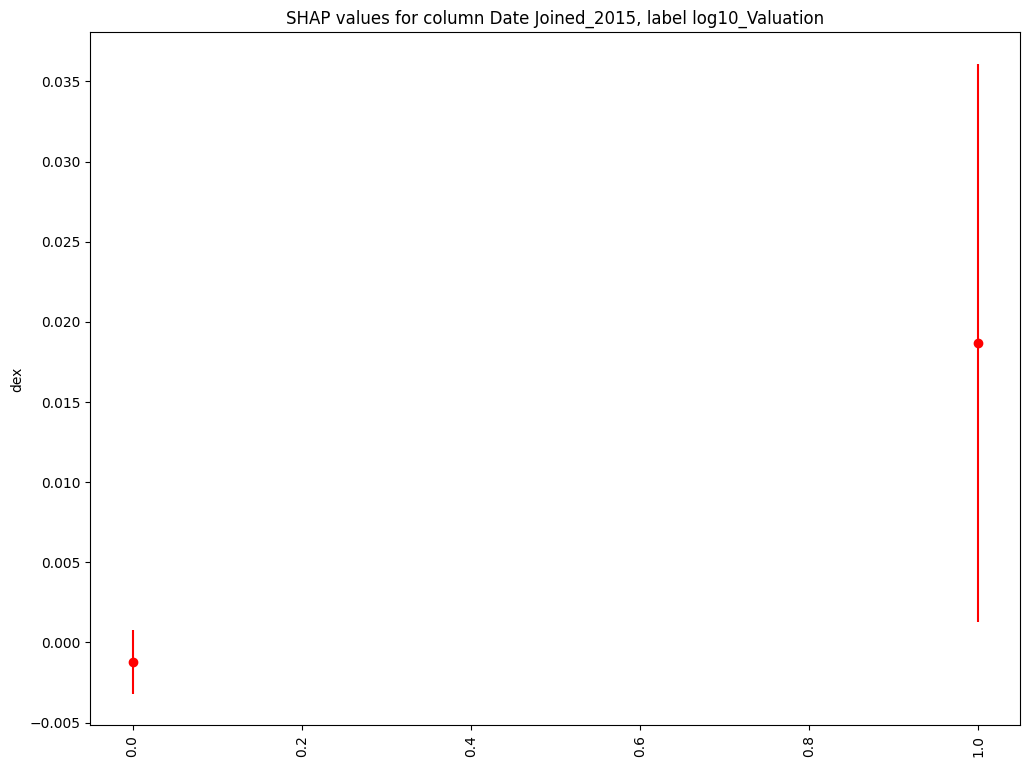

         gain  gain_std  count
col                           
True   0.0187    0.0174      8
False -0.0012    0.0020    234

Date Joined_2016



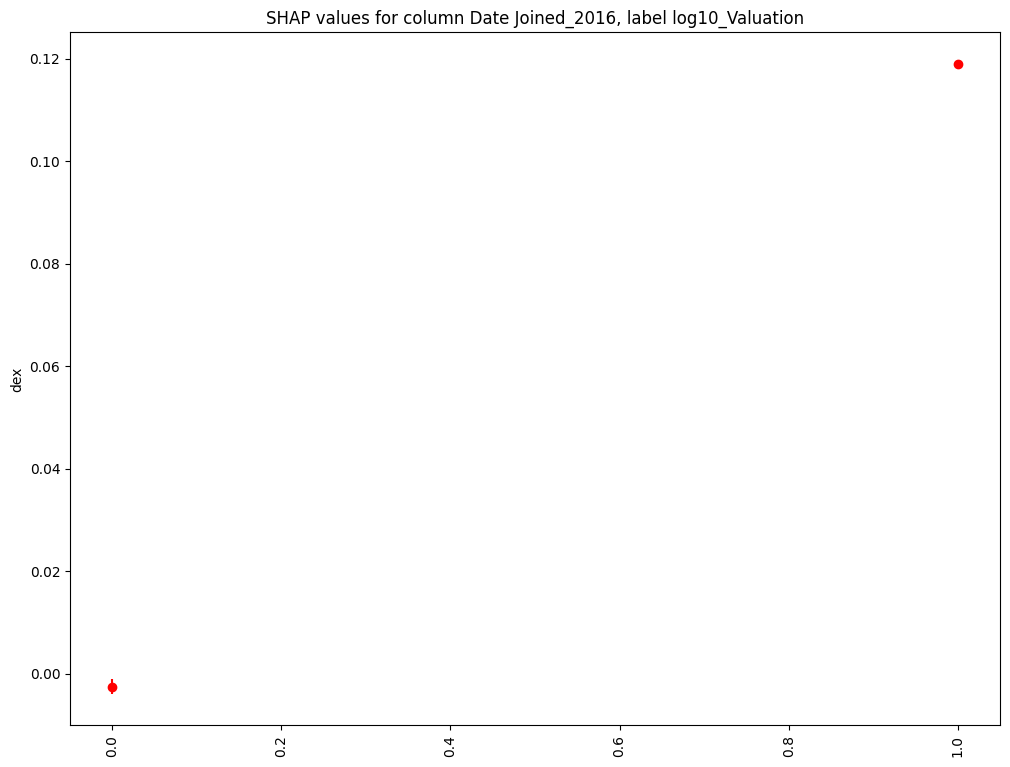

         gain  gain_std  count
col                           
True   0.1190    0.0000      4
False -0.0025    0.0014    238

Date Joined_2017



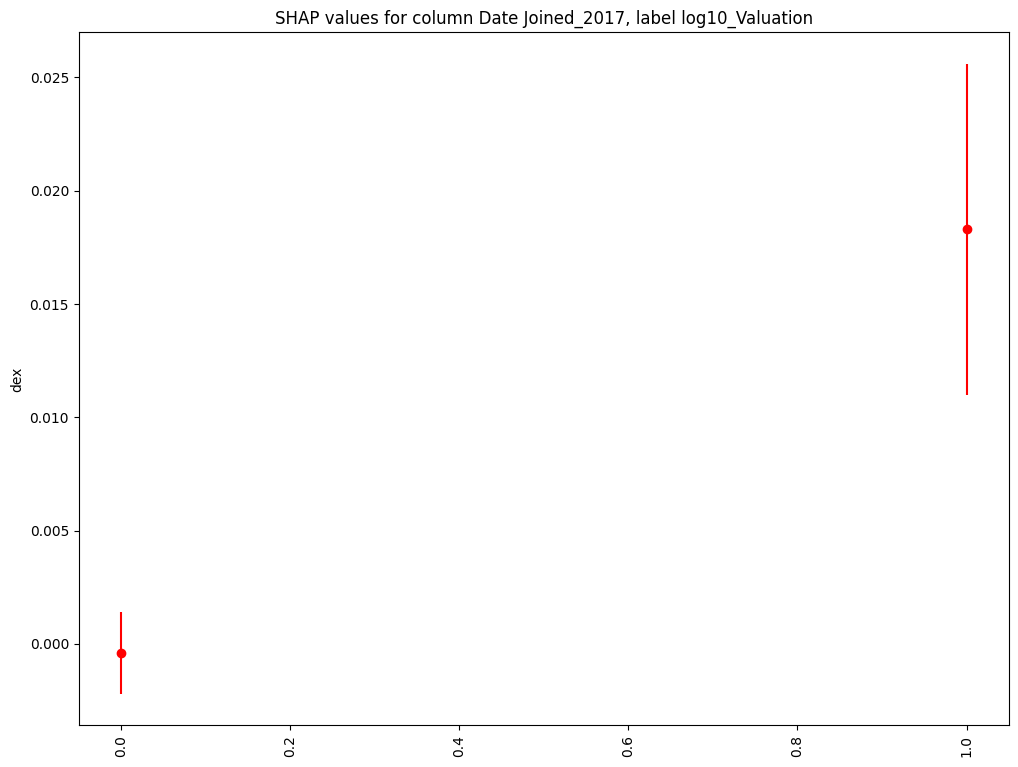

         gain  gain_std  count
col                           
True   0.0183    0.0073      4
False -0.0004    0.0018    238

Date Joined_2018



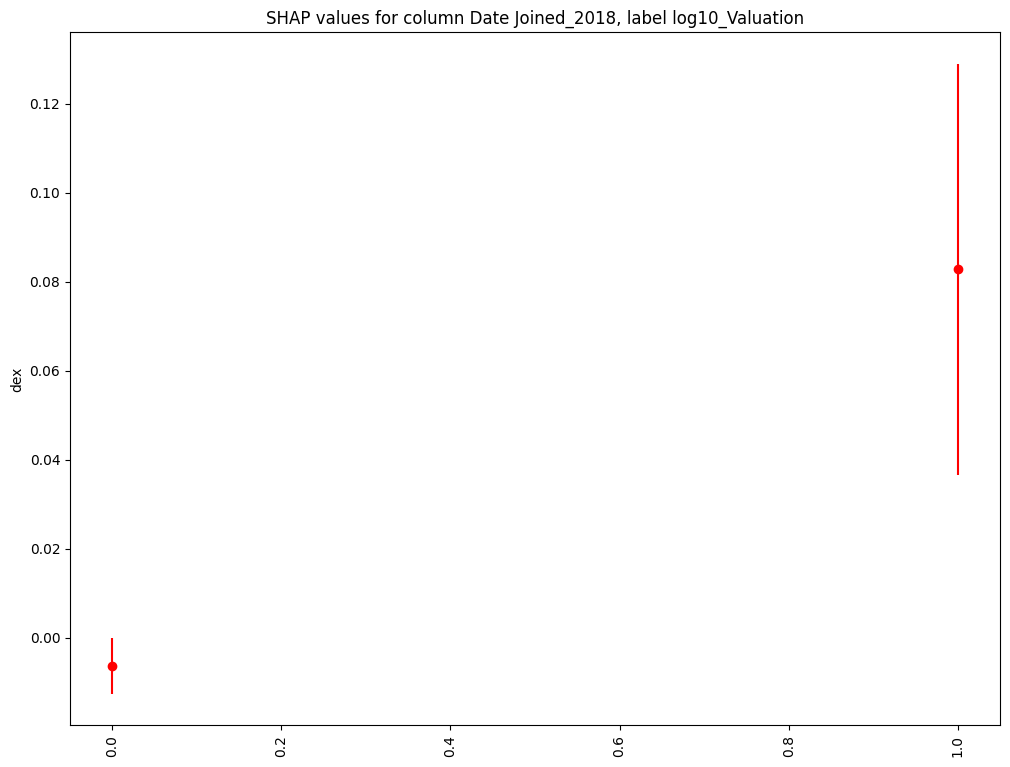

         gain  gain_std  count
col                           
True   0.0828    0.0462     22
False -0.0063    0.0063    220

Date Joined_2019



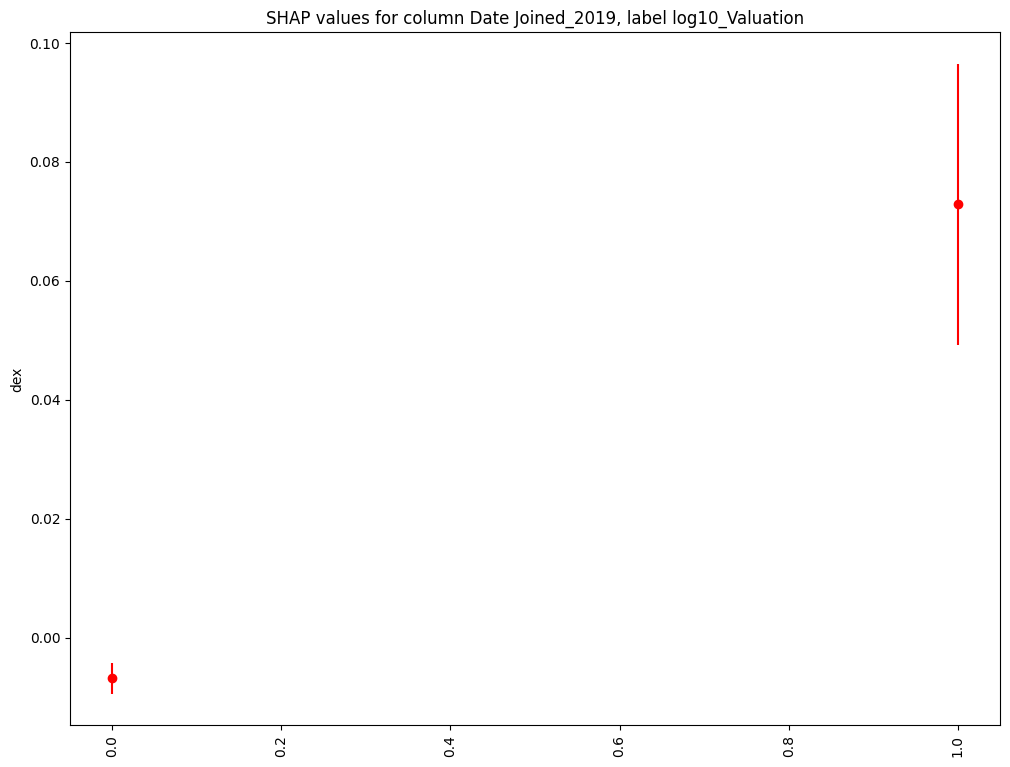

         gain  gain_std  count
col                           
True   0.0729    0.0236     22
False -0.0068    0.0026    220

Date Joined_2020



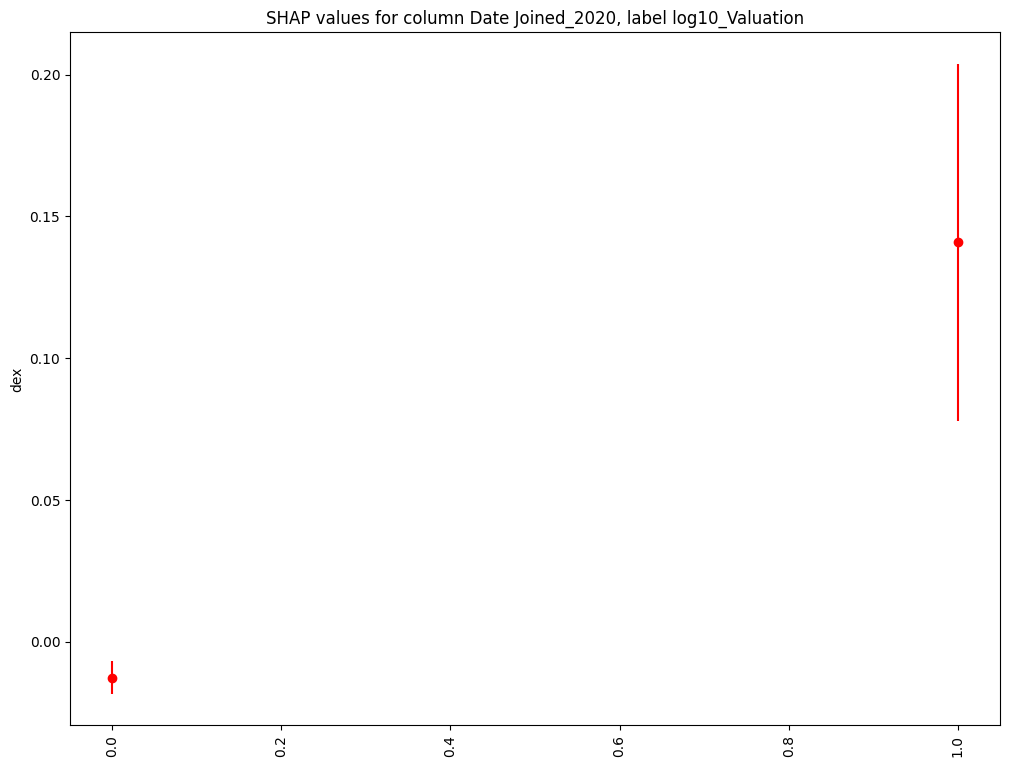

         gain  gain_std  count
col                           
True   0.1408    0.0630     24
False -0.0126    0.0057    218

Date Joined_2021



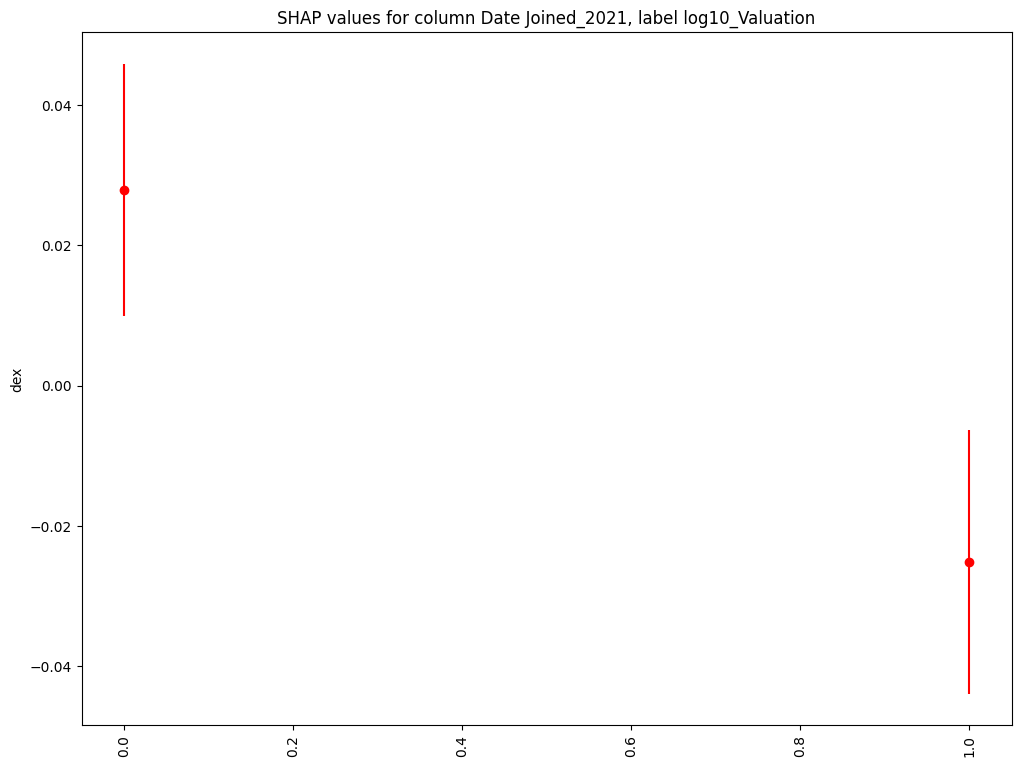

         gain  gain_std  count
col                           
False  0.0279    0.0180    155
True  -0.0251    0.0188     87

Date Joined_2022



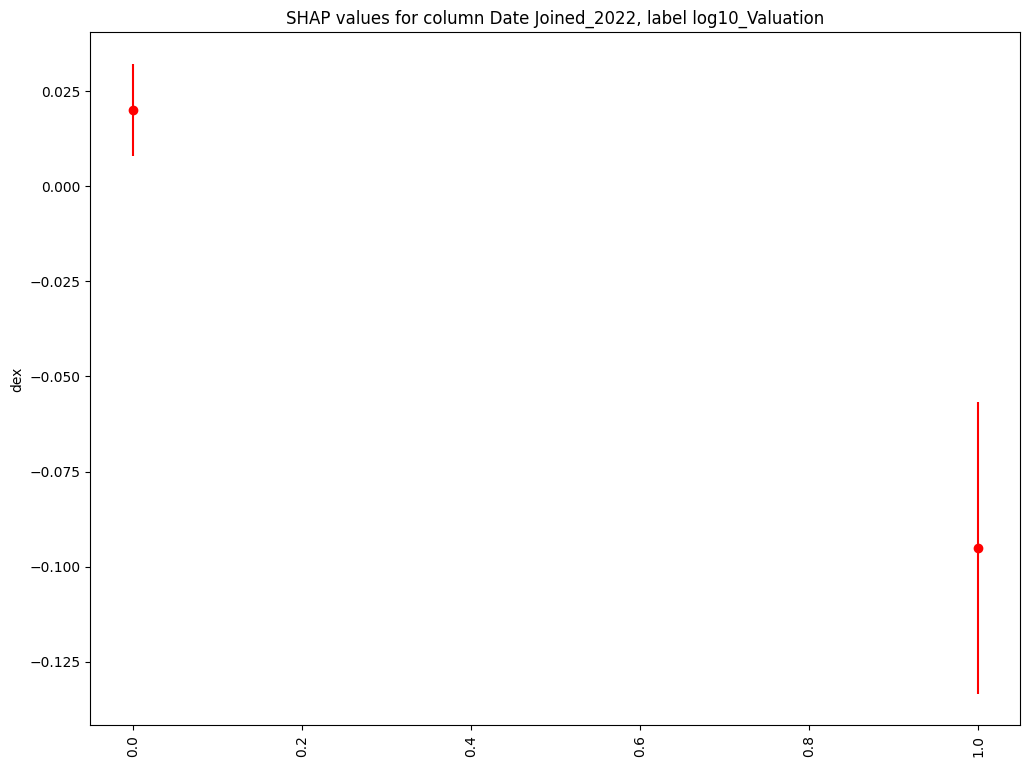

         gain  gain_std  count
col                           
False  0.0201    0.0121    174
True  -0.0951    0.0383     68

Date Joined_2023



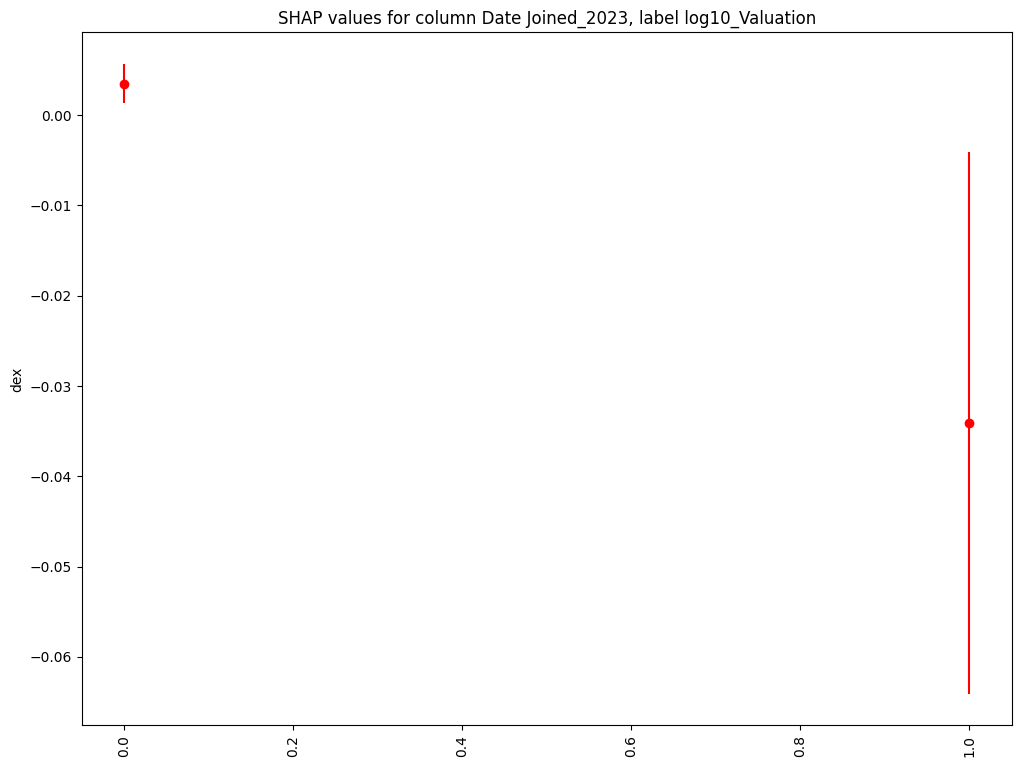

         gain  gain_std  count
col                           
False  0.0035    0.0022    239
True  -0.0341    0.0300      3

City_Beijing, China



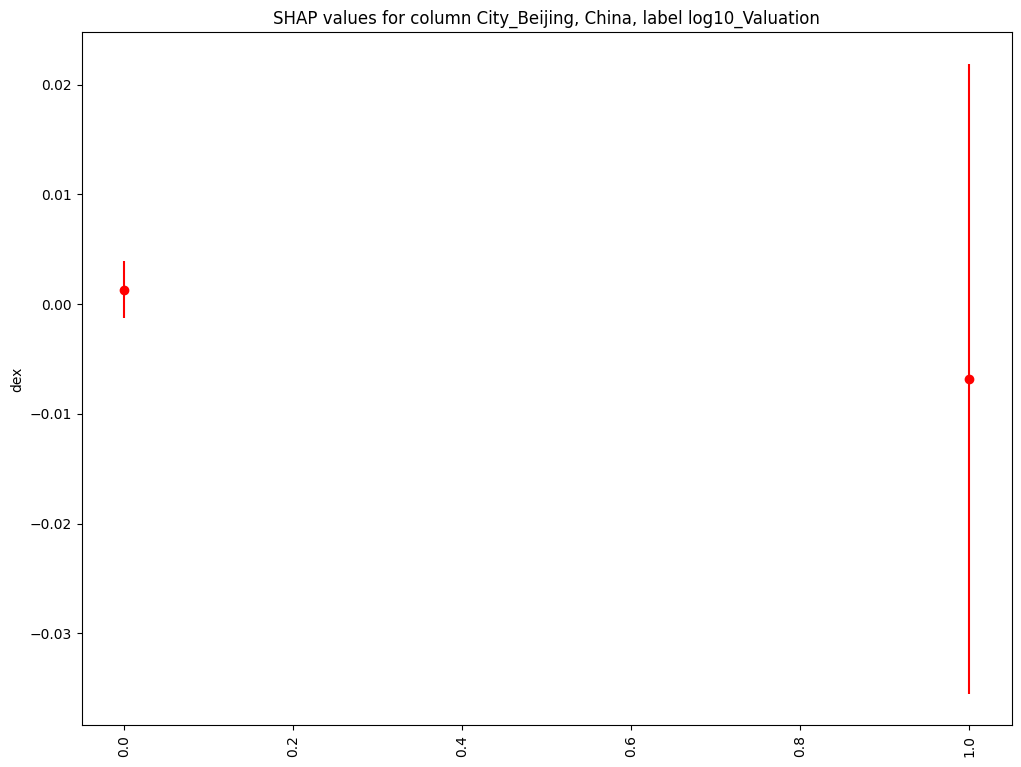

         gain  gain_std  count
col                           
False  0.0013    0.0026    233
True  -0.0068    0.0287      9

City_Bengaluru, India



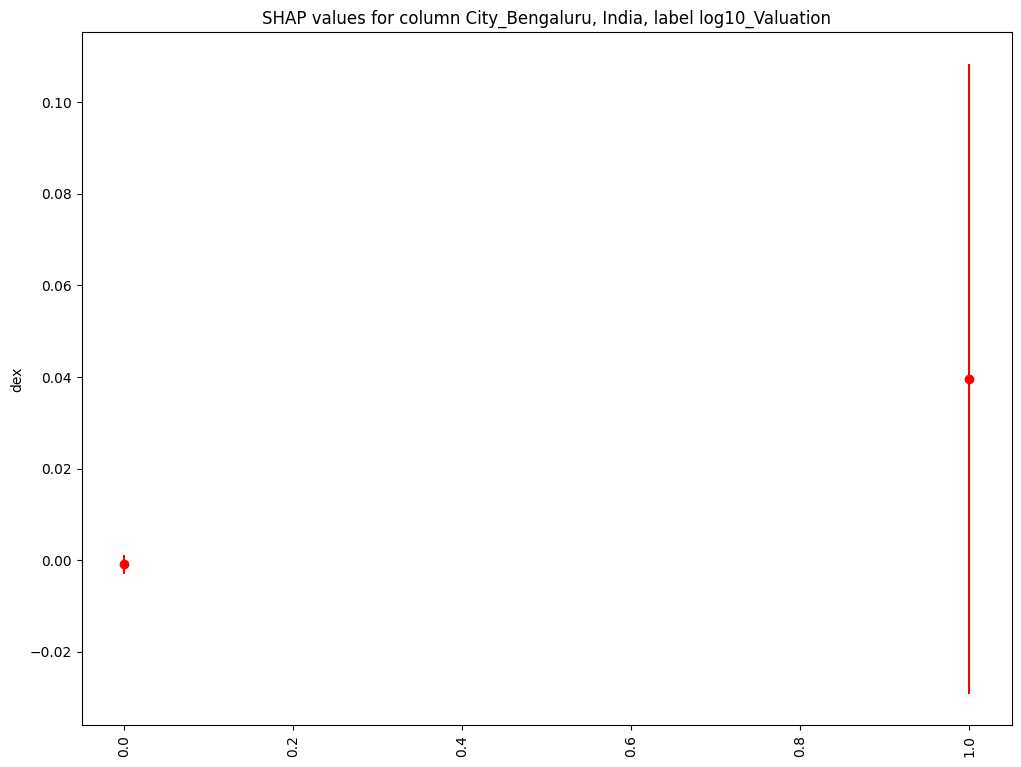

         gain  gain_std  count
col                           
True   0.0396    0.0688      5
False -0.0009    0.0021    237

City_Boston, United States



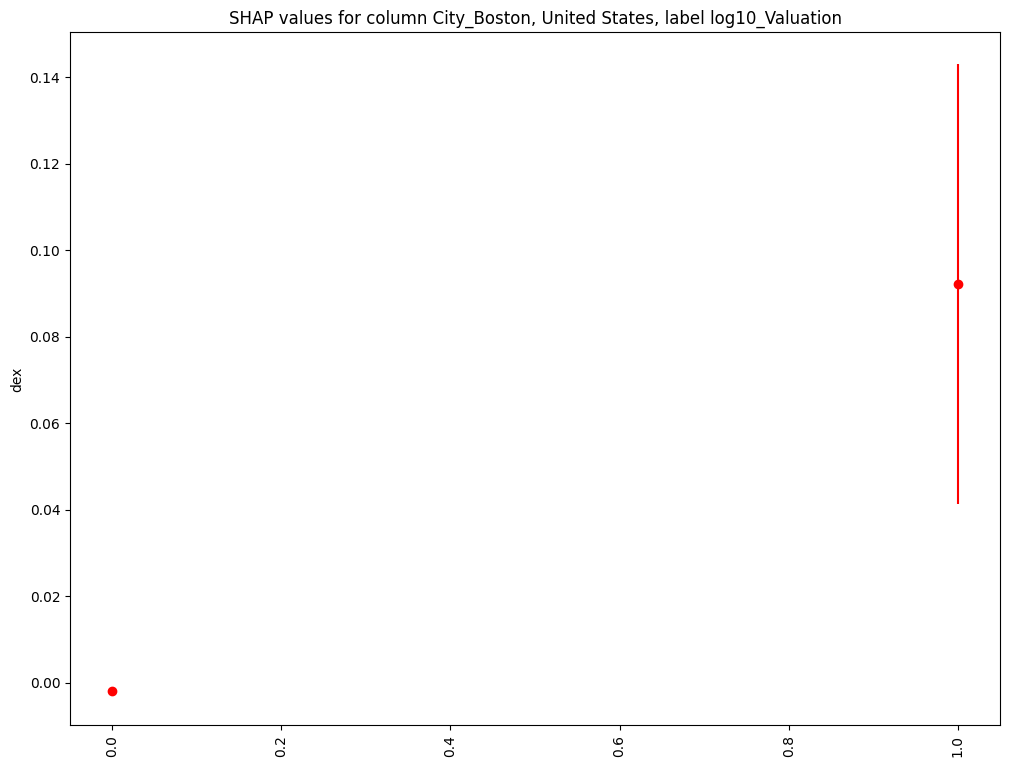

         gain  gain_std  count
col                           
True   0.0922    0.0509      5
False -0.0019    0.0007    237

City_London, United Kingdom



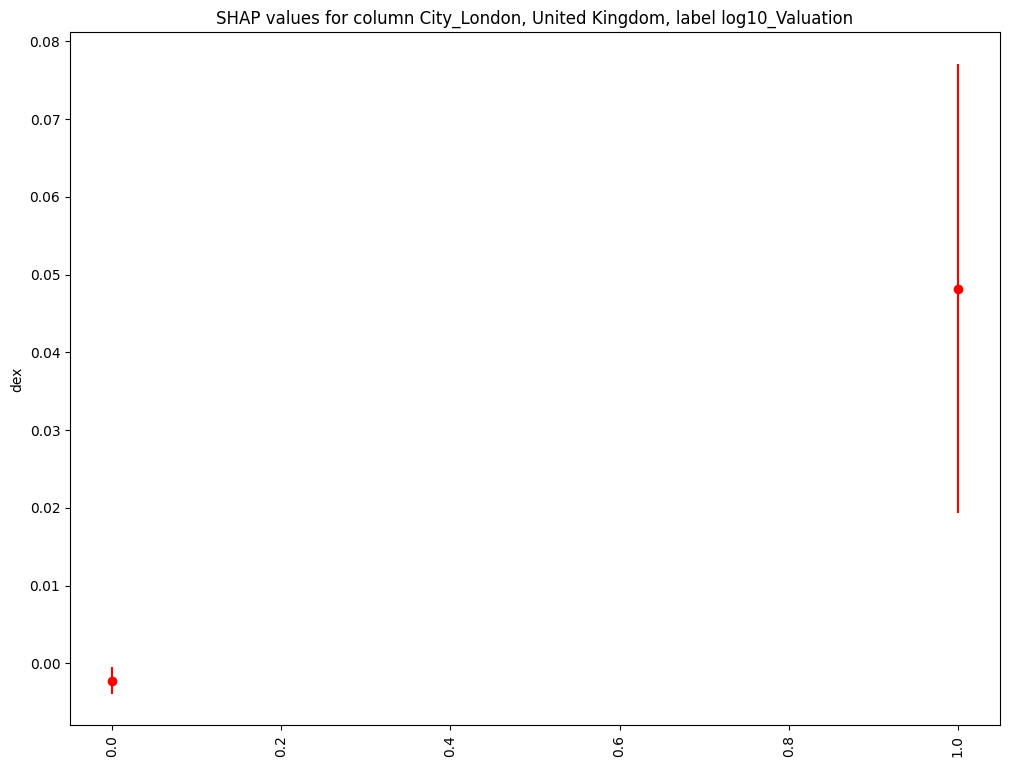

         gain  gain_std  count
col                           
True   0.0482    0.0289     10
False -0.0022    0.0017    232

City_New York, United States



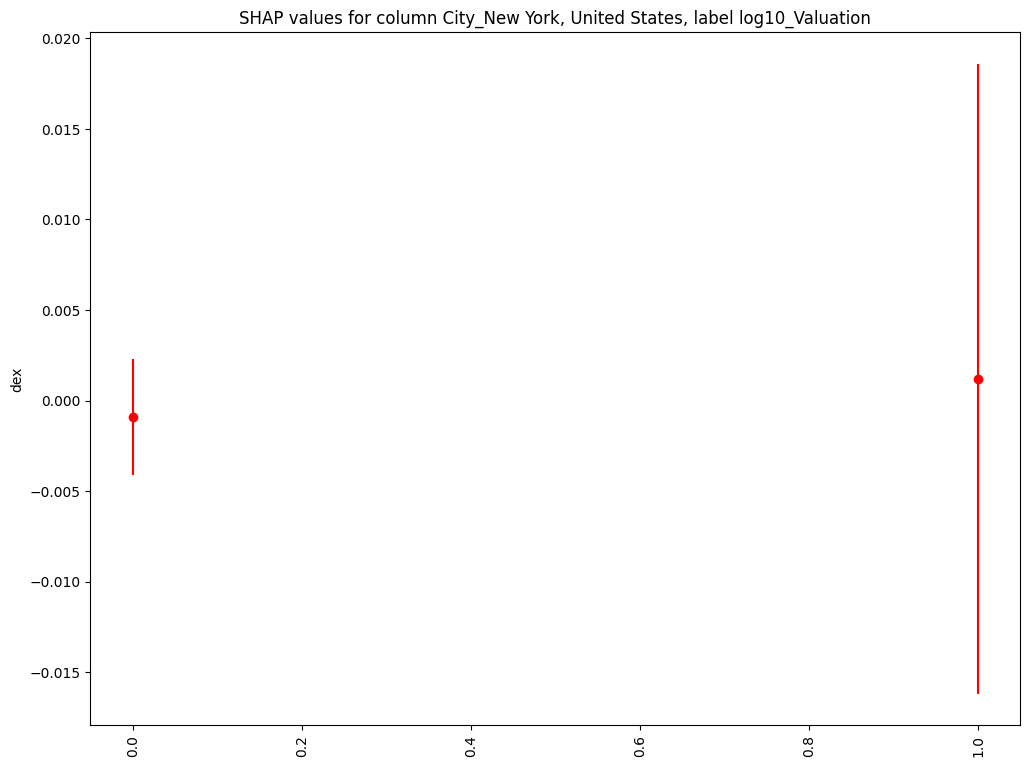

         gain  gain_std  count
col                           
True   0.0012    0.0174     23
False -0.0009    0.0032    219

City_Other



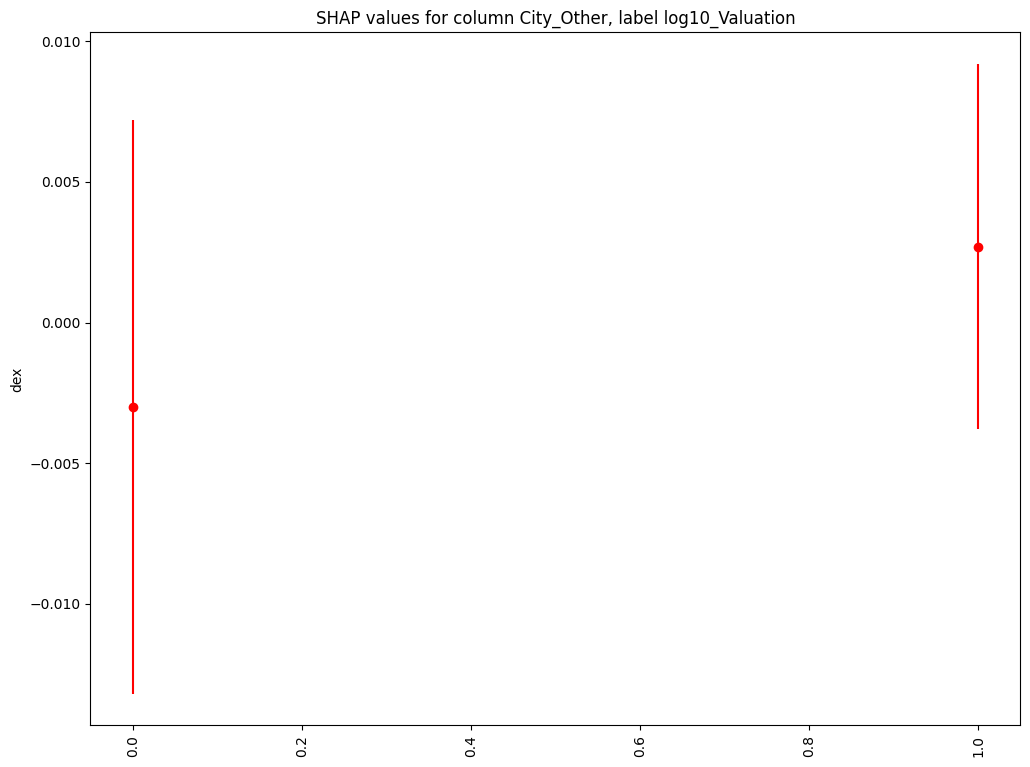

         gain  gain_std  count
col                           
True   0.0027    0.0065    140
False -0.0030    0.0102    102

City_Palo Alto, United States



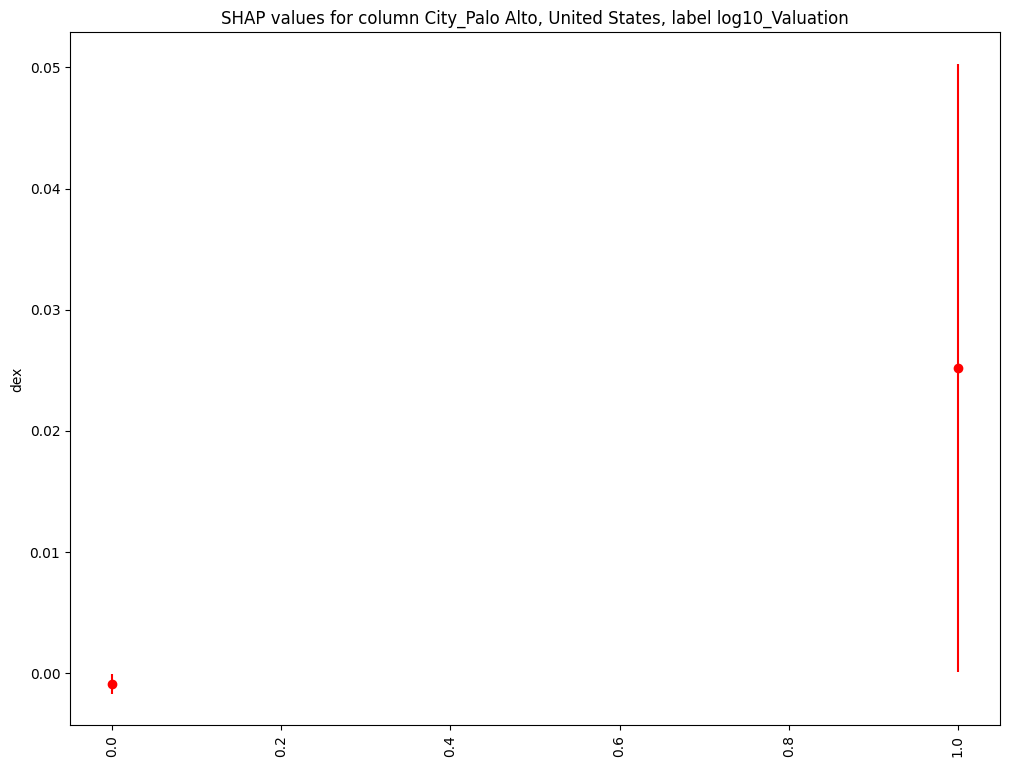

         gain  gain_std  count
col                           
True   0.0252    0.0251      7
False -0.0009    0.0008    235

City_Paris, France



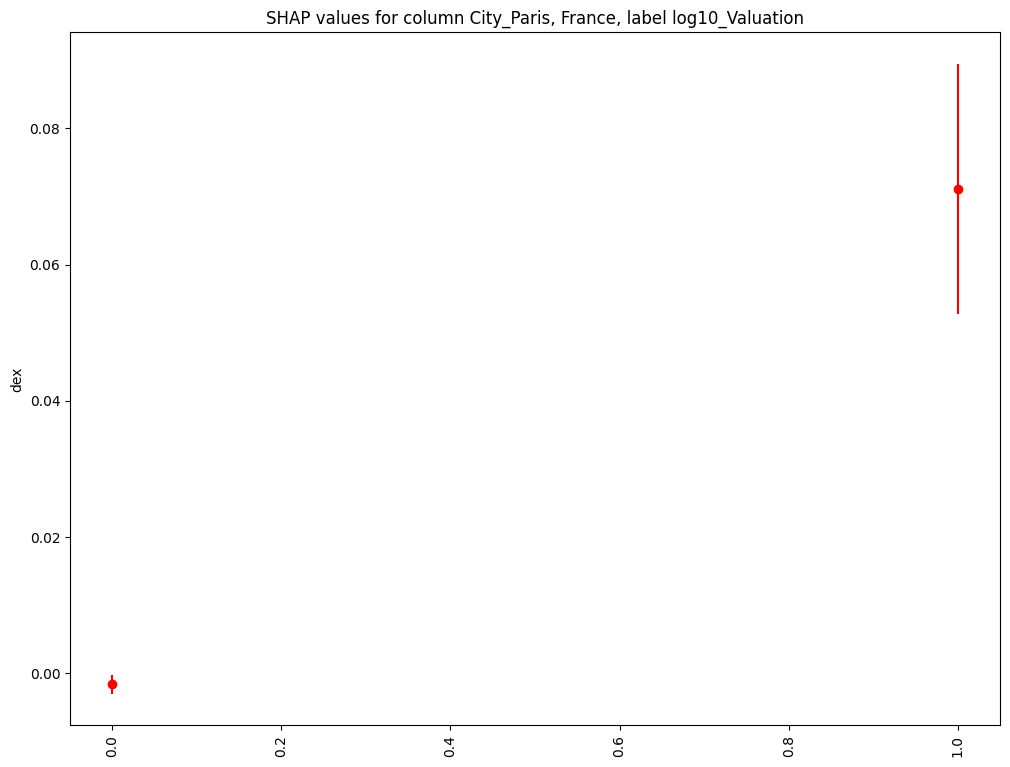

         gain  gain_std  count
col                           
True   0.0711    0.0184      3
False -0.0016    0.0014    239

City_San Francisco, United States



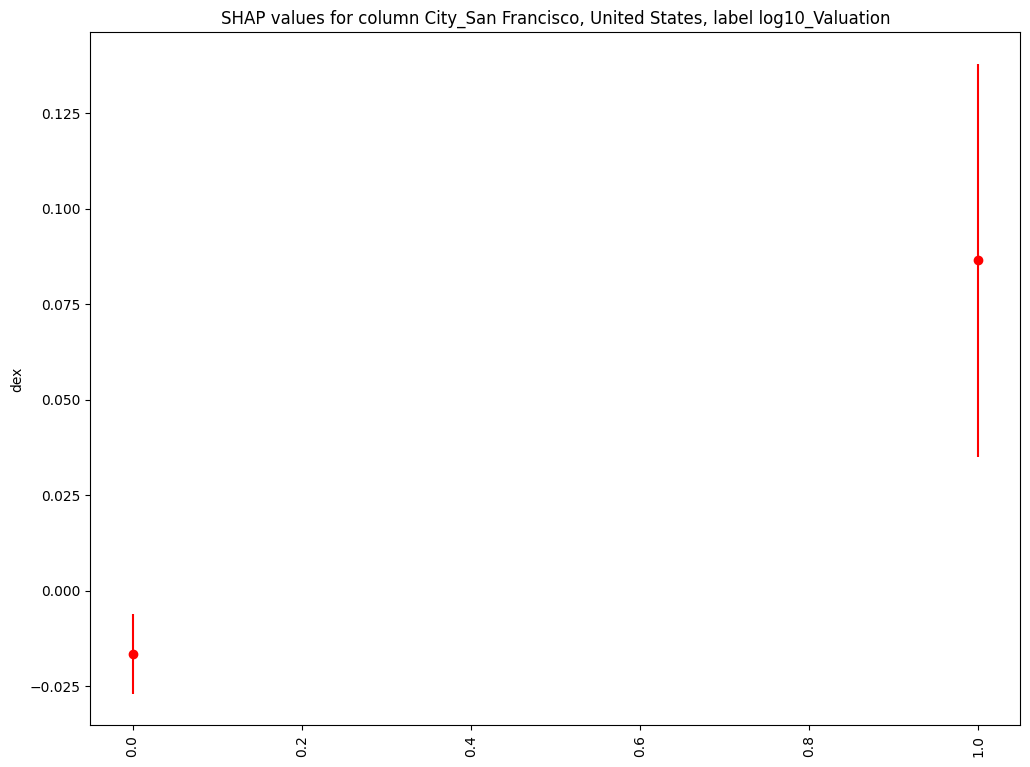

         gain  gain_std  count
col                           
True   0.0865    0.0515     32
False -0.0165    0.0105    210

City_Shanghai, China



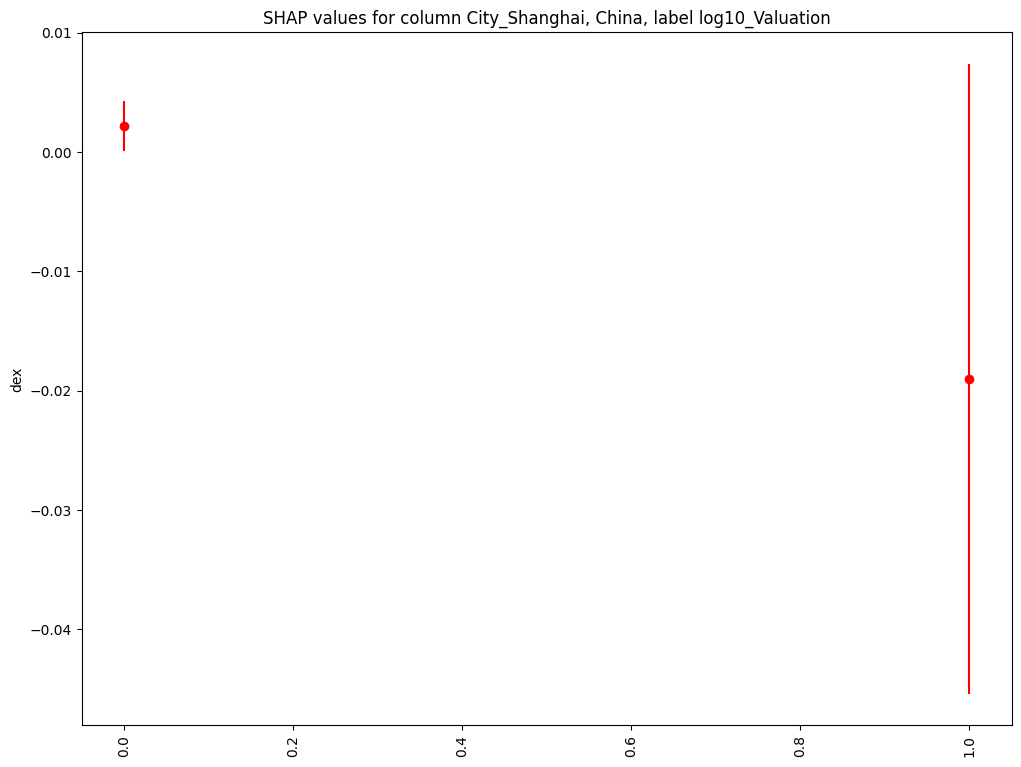

         gain  gain_std  count
col                           
False  0.0022    0.0021    234
True  -0.0190    0.0264      8

Industry_Consumer & Retail



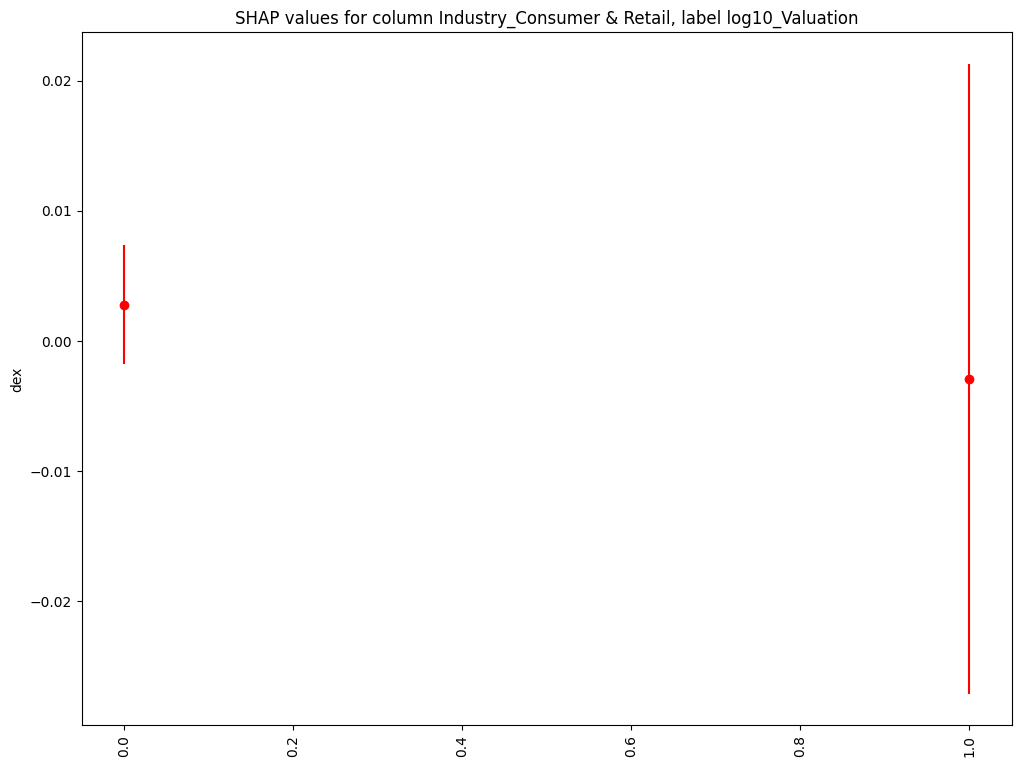

         gain  gain_std  count
col                           
False  0.0028    0.0046    199
True  -0.0029    0.0242     43

Industry_Enterprise Tech



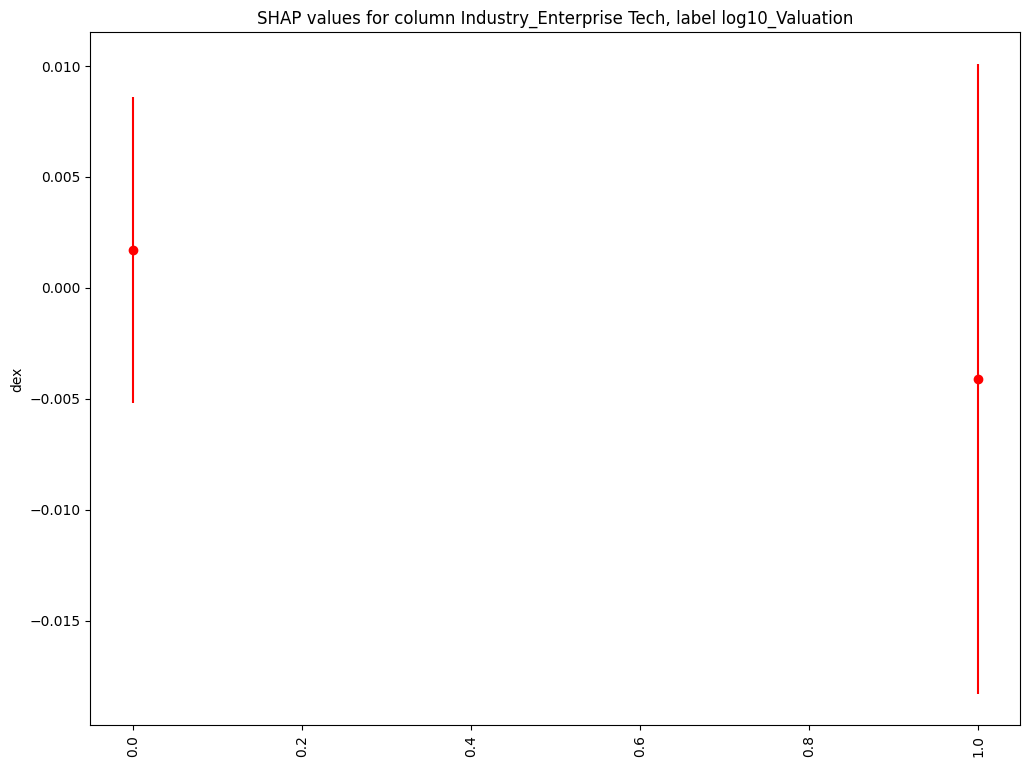

         gain  gain_std  count
col                           
False  0.0017    0.0069    161
True  -0.0041    0.0142     81

Industry_Financial Services



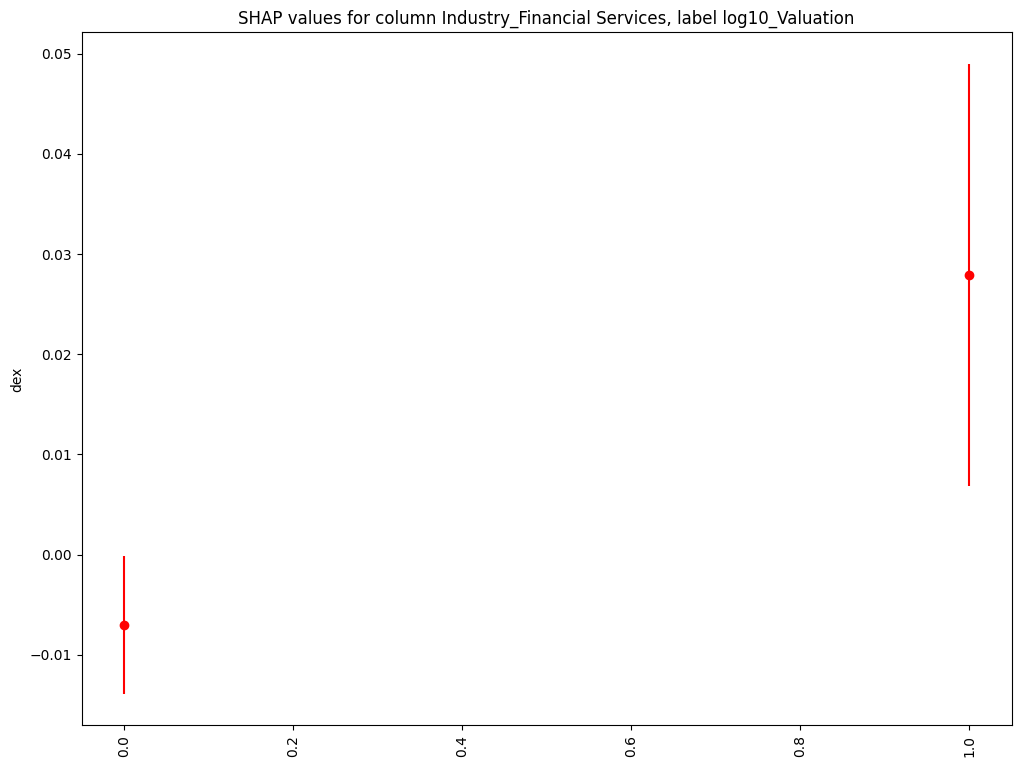

         gain  gain_std  count
col                           
True   0.0279    0.0211     39
False -0.0070    0.0069    203

Industry_Healthcare & Life Sciences



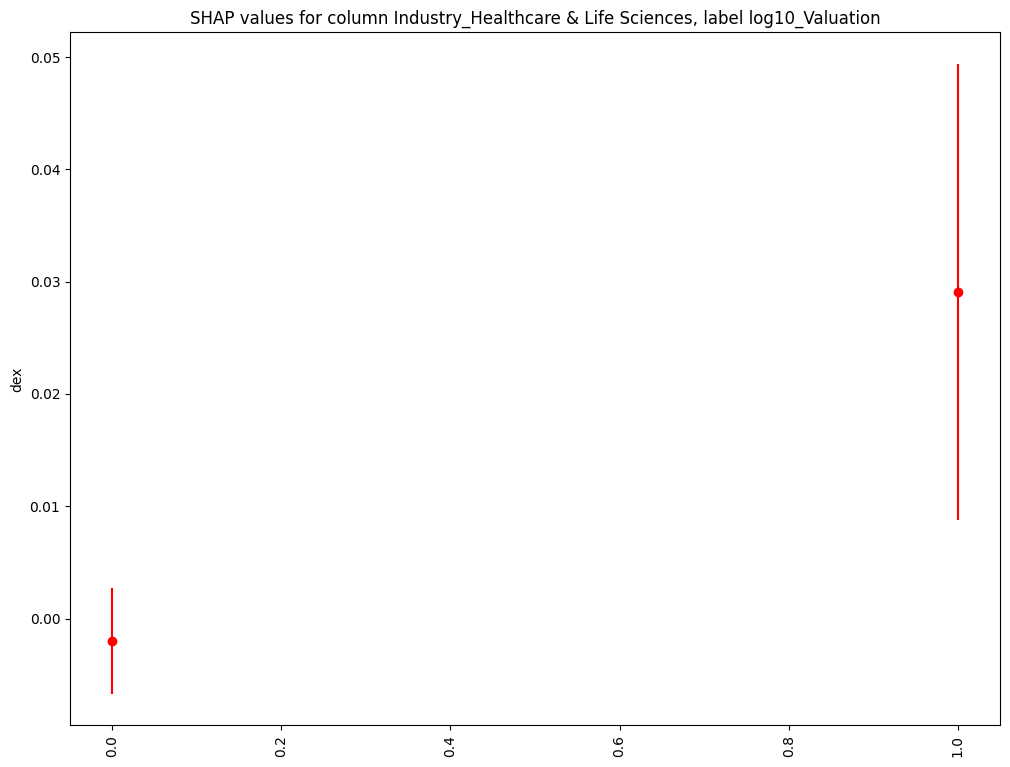

         gain  gain_std  count
col                           
True   0.0291    0.0203     18
False -0.0020    0.0047    224

Industry_Industrials



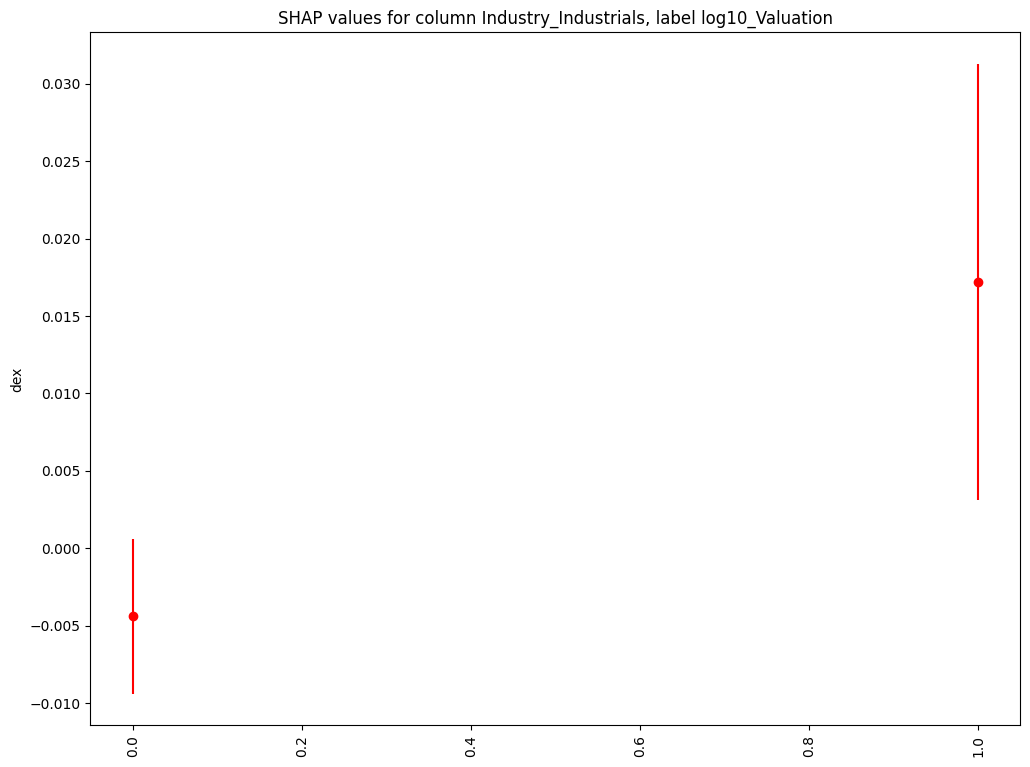

         gain  gain_std  count
col                           
True   0.0172    0.0141     41
False -0.0044    0.0050    201

Industry_Insurance



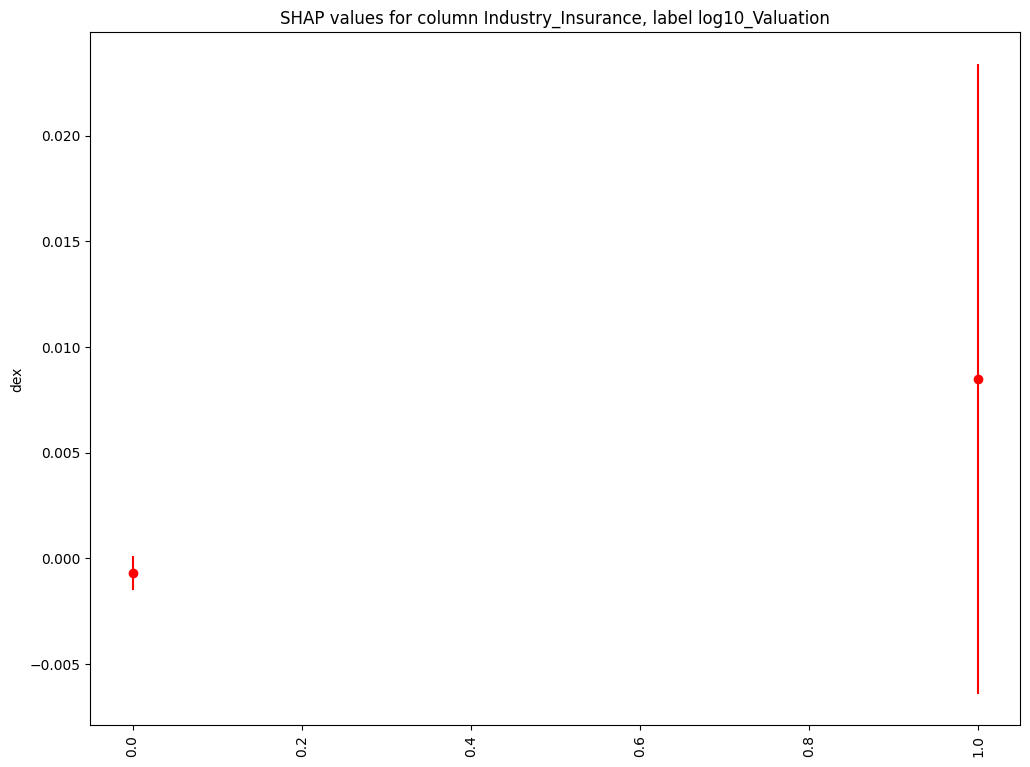

         gain  gain_std  count
col                           
True   0.0085    0.0149      5
False -0.0007    0.0008    237

Industry_Media & Entertainment



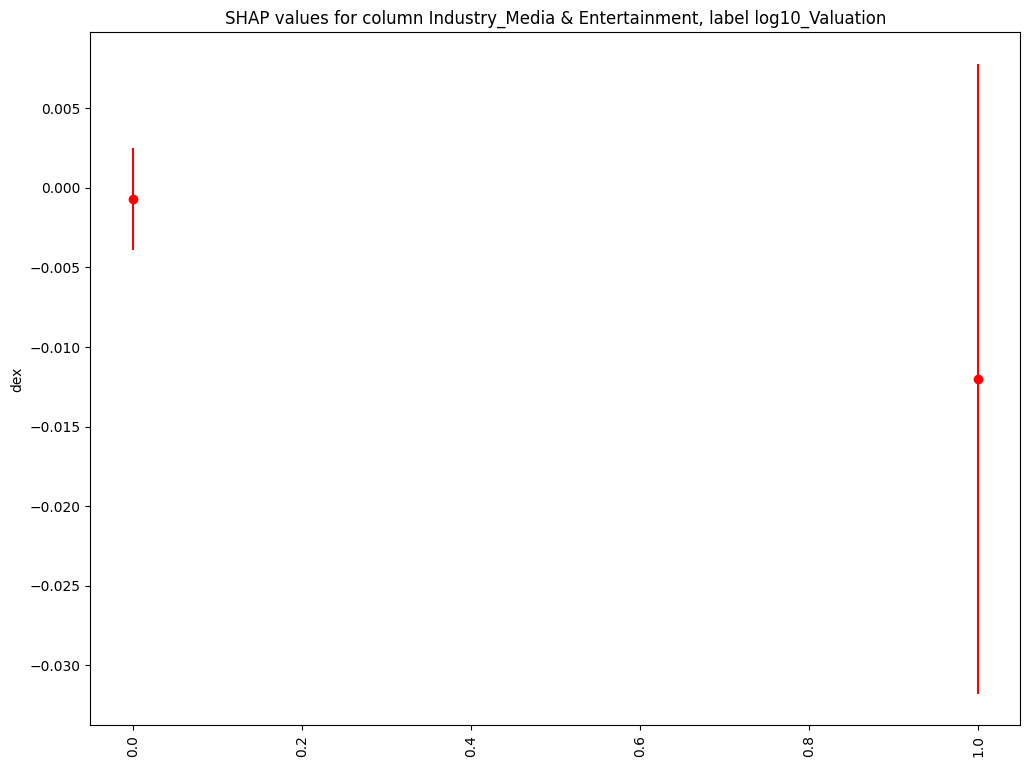

         gain  gain_std  count
col                           
False -0.0007    0.0032    227
True  -0.0120    0.0198     15


In [29]:
def show_shap(col, shap_values=shap_values, label=main_label, X_test=X_test, ylabel='dex'):
    df_infl = X_test.copy()
    df_infl['shap_'] = shap_values[:,df_infl.columns.tolist().index(col)]
    gain = round(df_infl.groupby(col).mean()['shap_'],4)
    gain_std = round(df_infl.groupby(col).std()['shap_'],4)
    cnt = df_infl.groupby(col).count()['shap_']
    dd_dict = {'col': list(gain.index), 'gain': list(gain.values), 'gain_std': list(gain_std.values), 'count': cnt}
    df_res = pd.DataFrame.from_dict(dd_dict).sort_values('gain', ascending=False).set_index('col')
    plt.figure(figsize=(12,9))
    plt.errorbar(df_res.index, df_res['gain'], yerr=df_res['gain_std'], fmt="o", color="r")
    plt.title(f'SHAP values for column {col}, label {label}')
    plt.ylabel(ylabel)
    plt.tick_params(axis="x", rotation=90)
    plt.show();
    print(df_res)
    return

for col in X_test.columns:
    if col.split('_')[0] not in ['Select Investors']:
        print()
        print(col)
        print()
        show_shap(col, shap_values, label=main_label, X_test=X_test)

# Visualization

**1. Distribution of Valuations**

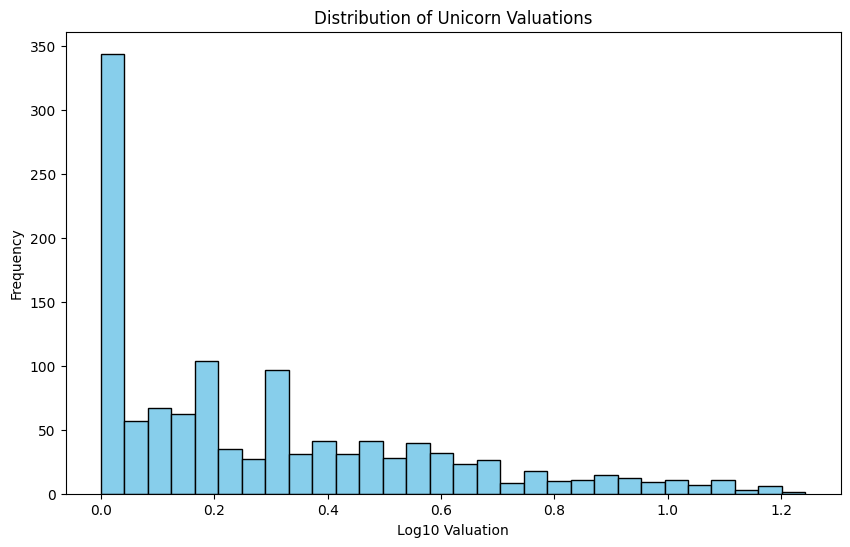

In [31]:
plt.figure(figsize=(10,6))
plt.hist(df['log10_Valuation'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Log10 Valuation')
plt.ylabel('Frequency')
plt.title('Distribution of Unicorn Valuations')
plt.show()

**2. Valuation by Industry**

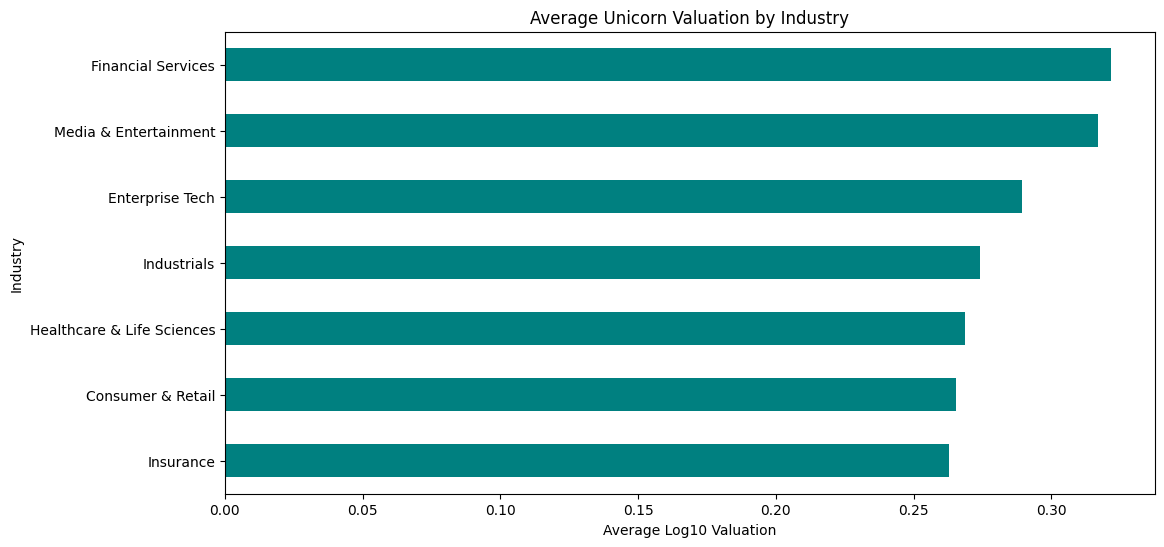

In [32]:
plt.figure(figsize=(12,6))
df.groupby('Industry')['log10_Valuation'].mean().sort_values().plot(kind='barh', color='teal')
plt.xlabel('Average Log10 Valuation')
plt.title('Average Unicorn Valuation by Industry')
plt.show()

**Conclusion: as per the projection, "Financial Services" value is more than the all industries.**

**3. Number of Unicorns by Year**

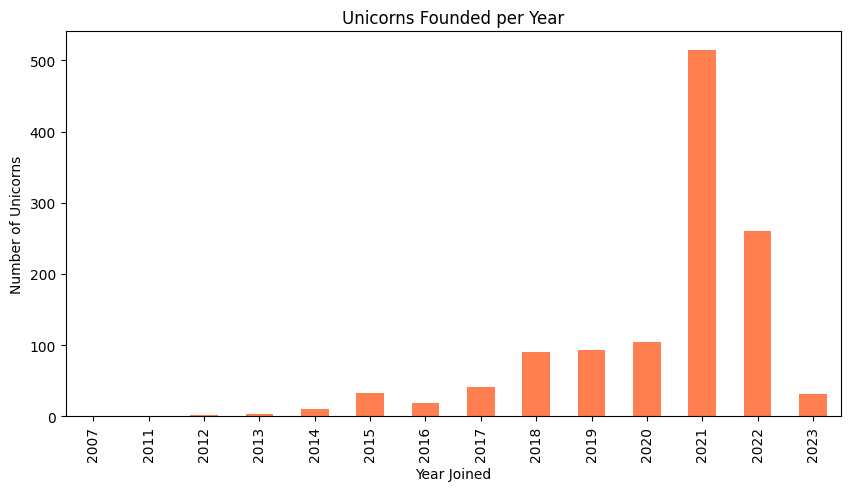

In [33]:
plt.figure(figsize=(10,5))
df['Date Joined'].value_counts().sort_index().plot(kind='bar', color='coral')
plt.xlabel('Year Joined')
plt.ylabel('Number of Unicorns')
plt.title('Unicorns Founded per Year')
plt.show()

**Conclusion: As given data, maximum unicorns founded in 2021, which is more than double to earlier stablished companies**

**4. Top Cities for Unicorns**

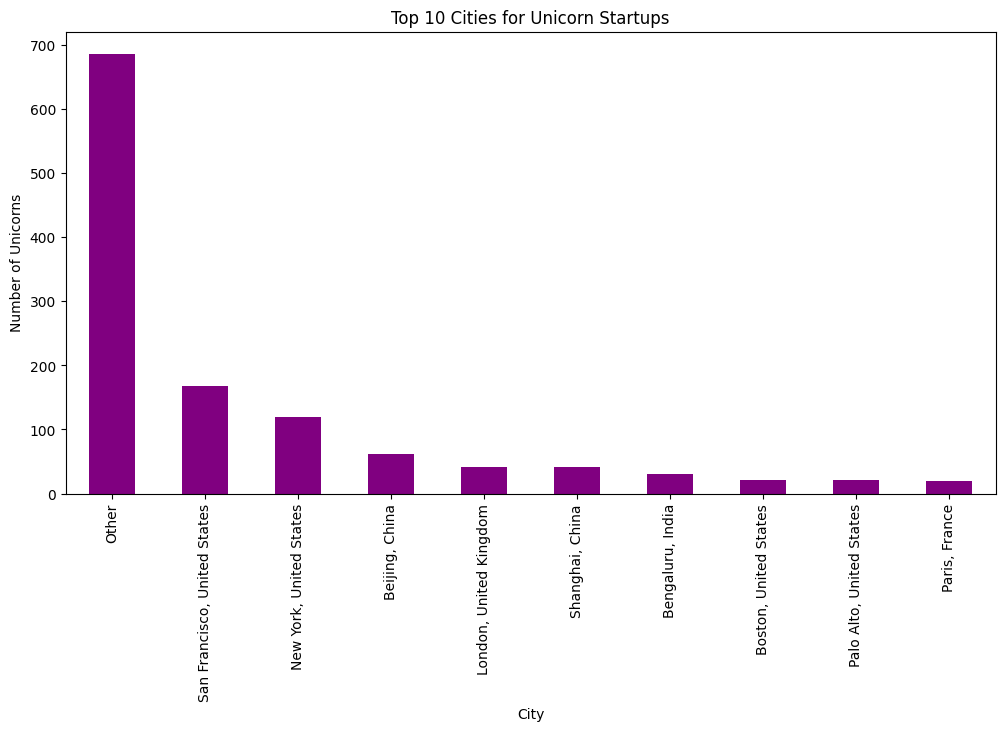

In [34]:
plt.figure(figsize=(12,6))
df['City'].value_counts().head(10).plot(kind='bar', color='purple')
plt.xlabel('City')
plt.ylabel('Number of Unicorns')
plt.title('Top 10 Cities for Unicorn Startups')
plt.show()

**Conclusion:**

- **As per visual, "San Francisco" is the top most location to stablish as a new startup and run as unicorn and after that "New York" and then "Beijing" is the 3rd top most location to do the same.**

- **In context of "India", "Bengaluru" is the top 6th location to stablish a startup and nurture to get Unicorn status.**

**5. Correlation Heatmap of Numeric Features**

In [36]:
import seaborn as sns

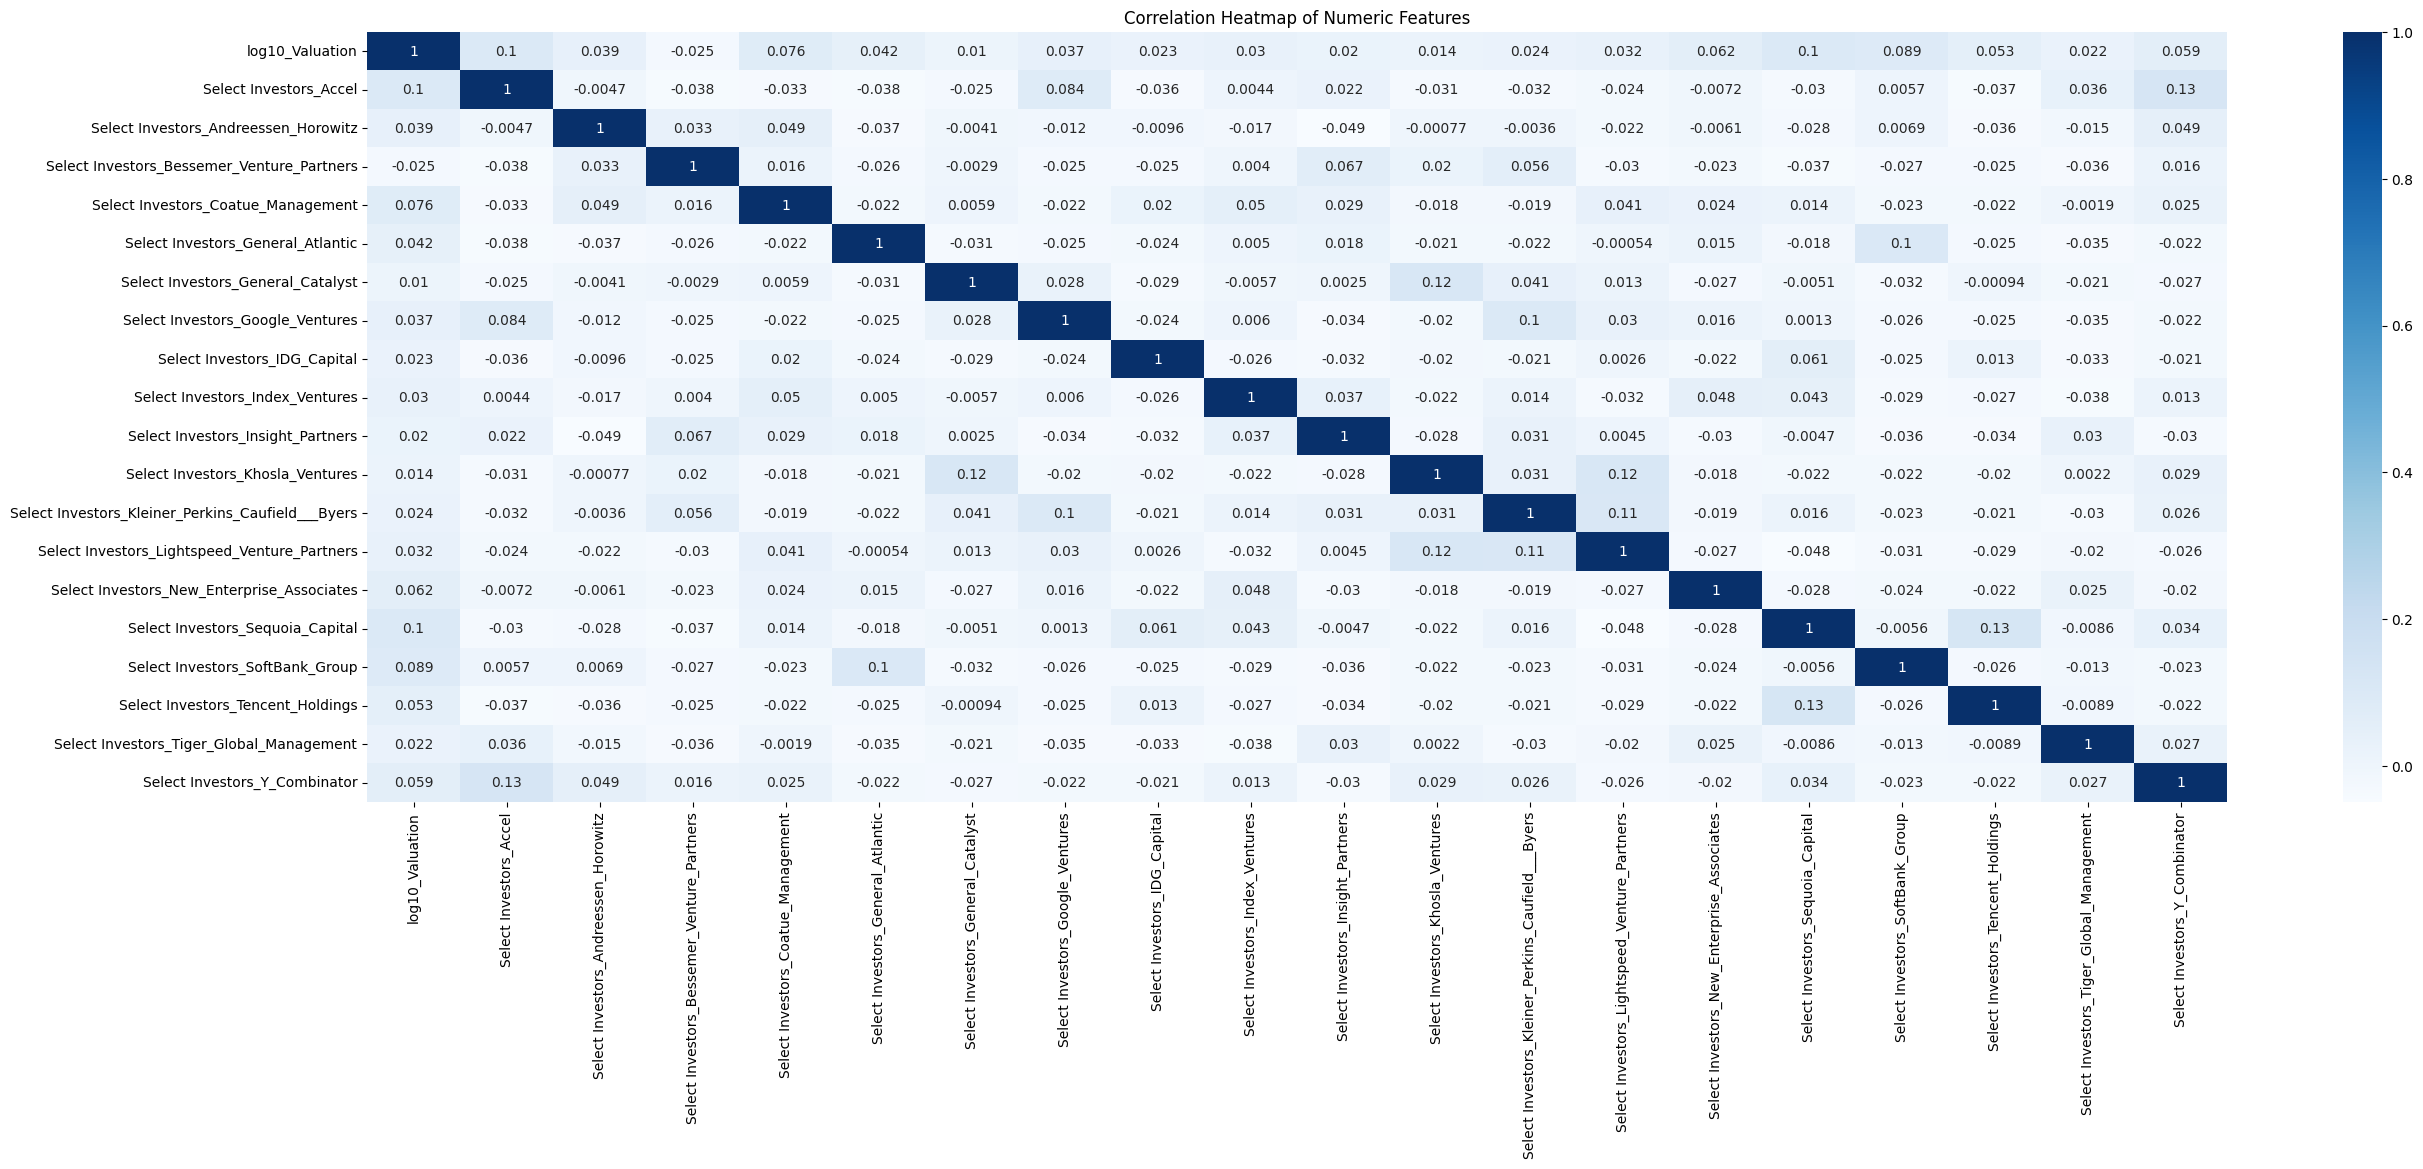

In [40]:
plt.figure(figsize=(30,10))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='Blues')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

**Conclusion:**

- The pairplot provides a comprehensive overview of the relationships between all numeric features in the unicorn dataset. It helps identify potential correlations, clusters, and outliers among variables.

**6. Valuation vs. Number of Investors**

In [49]:
if 'Select Investors' in df.columns:
    df['num_investors'] = df['Select Investors'].apply(lambda x: len(str(x).split(',')))
    plt.figure(figsize=(10,6))
    plt.scatter(df['num_investors'], df['log10_Valuation'], alpha=0.6)
    plt.xlabel('Number of Investors')
    plt.ylabel('Log10 Valuation')
    plt.title('Valuation vs. Number of Investors')
    plt.show()

**7. Boxplot of Valuations by Industry**

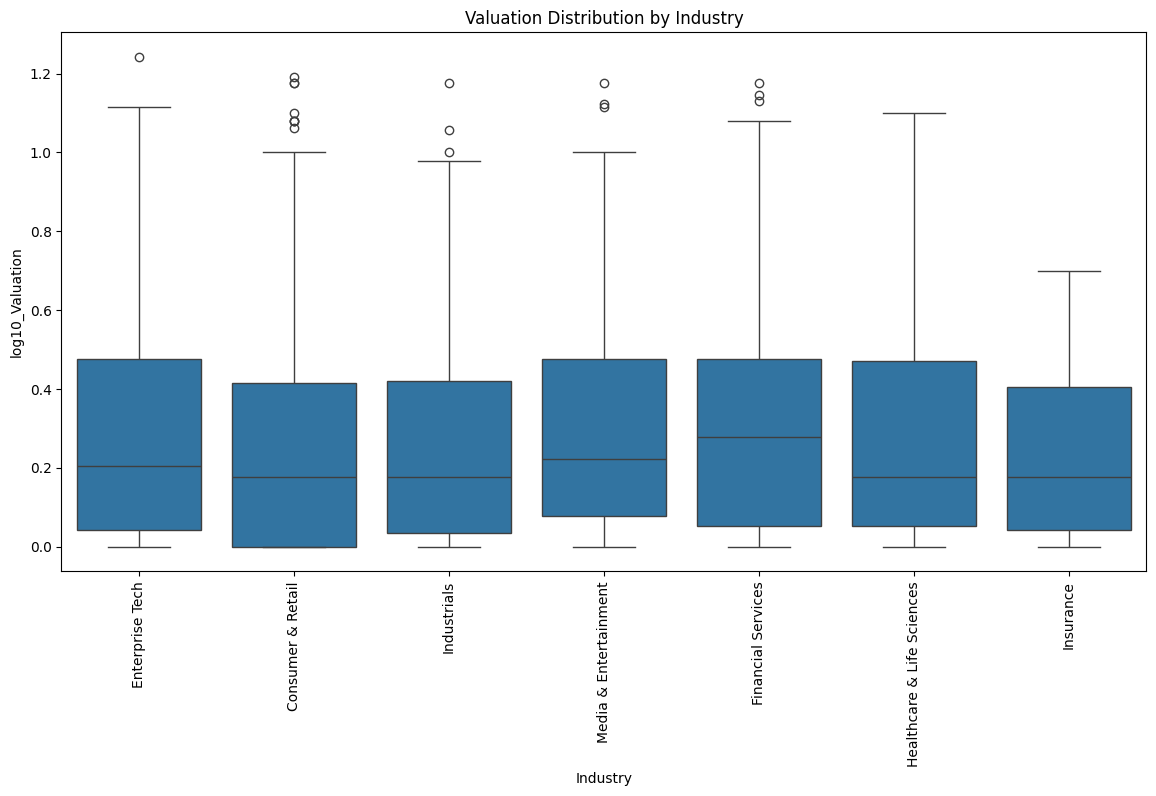

In [50]:
plt.figure(figsize=(14,7))
sns.boxplot(x='Industry', y='log10_Valuation', data=df)
plt.xticks(rotation=90)
plt.title('Valuation Distribution by Industry')
plt.show()

Conclusion:
- In visual, 'Enterprise Tech', 'Media & Entertainment','Financial Services' and 'Healthcare & Life Sciences' are the top valuation industry with the high pop-up volume.
- In which, 'Enterprise Tech' has high volume to grow and 'Healthcare and Life Sciences' is the second one in higher volume.

**8. Pie Chart of Industry Distribution**

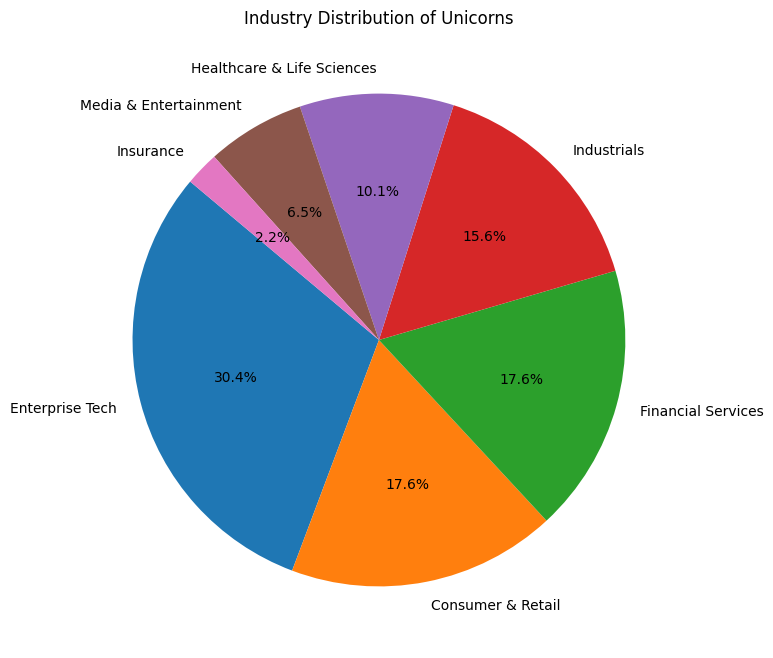

In [51]:
plt.figure(figsize=(8,8))
df['Industry'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140)
plt.title('Industry Distribution of Unicorns')
plt.ylabel('')
plt.show()

Key Observations:
- Enterprise Tech dominates with 30.4%
- Consumer & Retail and Financial Services are next with 17.6% each
- Smaller contributions from Insurance (2.2%) and Media & Entertainment (6.5%)

**9. Bar Plot of Top 10 Investors by Number of Unicorns**

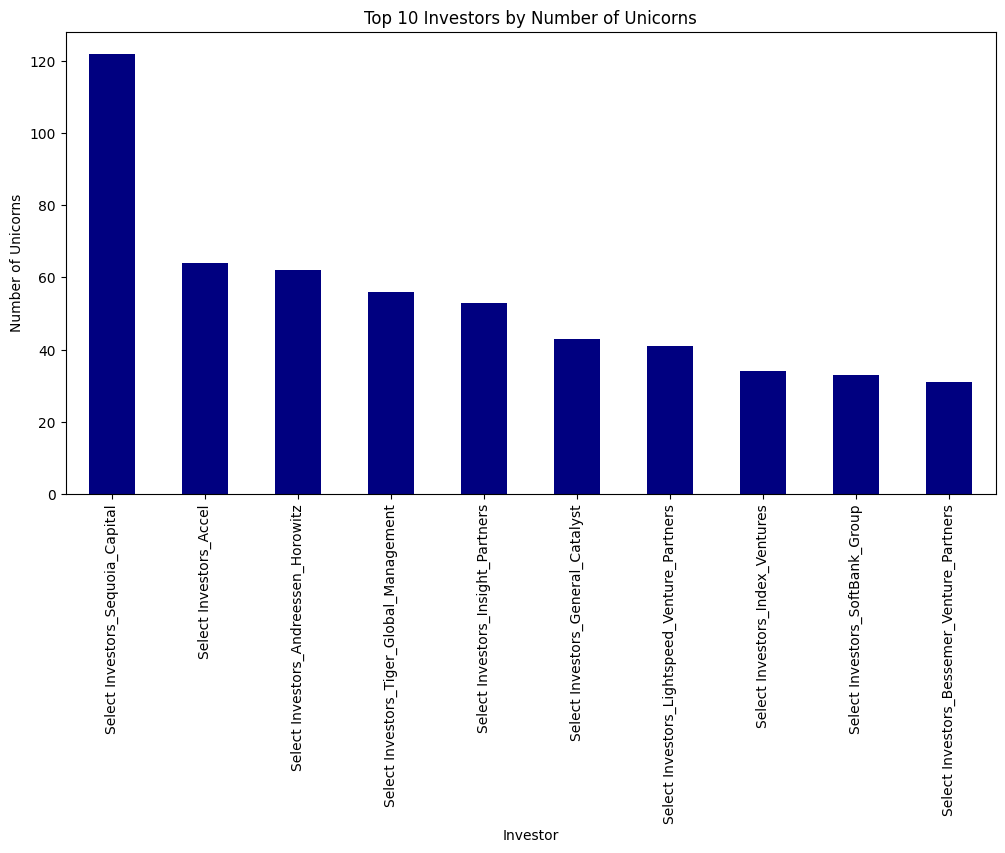

In [53]:
# Get all investor columns
investor_cols = [col for col in df.columns if col.startswith('Select Investors_')]
# Count unicorns for each investor
investor_counts = df[investor_cols].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
investor_counts.plot(kind='bar', color='navy')
plt.title('Top 10 Investors by Number of Unicorns')
plt.xlabel('Investor')
plt.ylabel('Number of Unicorns')
plt.show()

Insights:
- Sequoia Capital is the clear leader, having invested in 120+ unicorns, showcasing its dominance and early bet strategy in high-potential startups.

**10.Scatter Plot: Valuation vs. Year Joined**

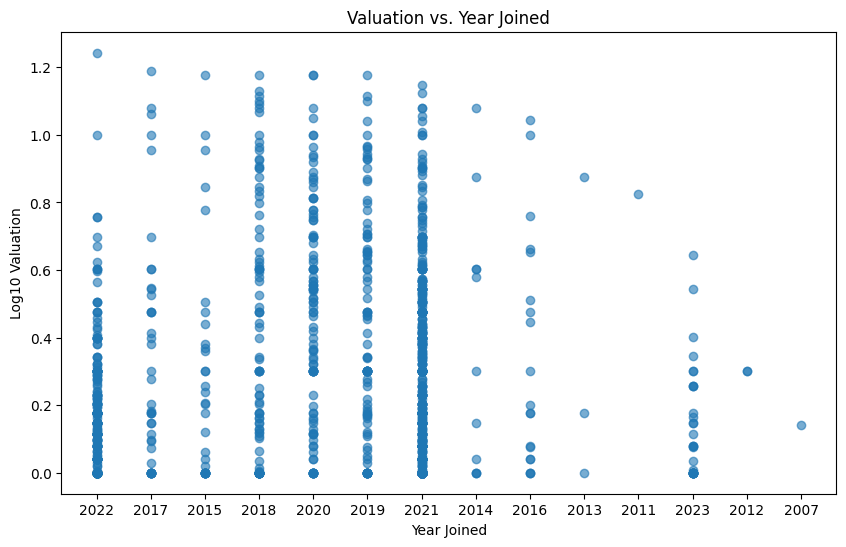

In [54]:
plt.figure(figsize=(10,6))
plt.scatter(df['Date Joined'], df['log10_Valuation'], alpha=0.6)
plt.xlabel('Year Joined')
plt.ylabel('Log10 Valuation')
plt.title('Valuation vs. Year Joined')
plt.show()

Conclusion:
- 2018 to 2021 was a boom period for unicorn creation, with frequent and highly valued entries-possibly driven by tech growth, easy funding, and innovation waves.
- Valuations spiked during this phase, with many reaching multi-billion-dollar levels.
- Post-2021 shows a slowdown, both in volume and valuation, possibly due to market corrections, investor caution, or macroeconomic factors.
- Long-term, this pattern may highlight the cyclical nature of unicorn funding trends and how external economic conditions affect startup growth.

**11. Heatmap of Unicorns by City and Industry**

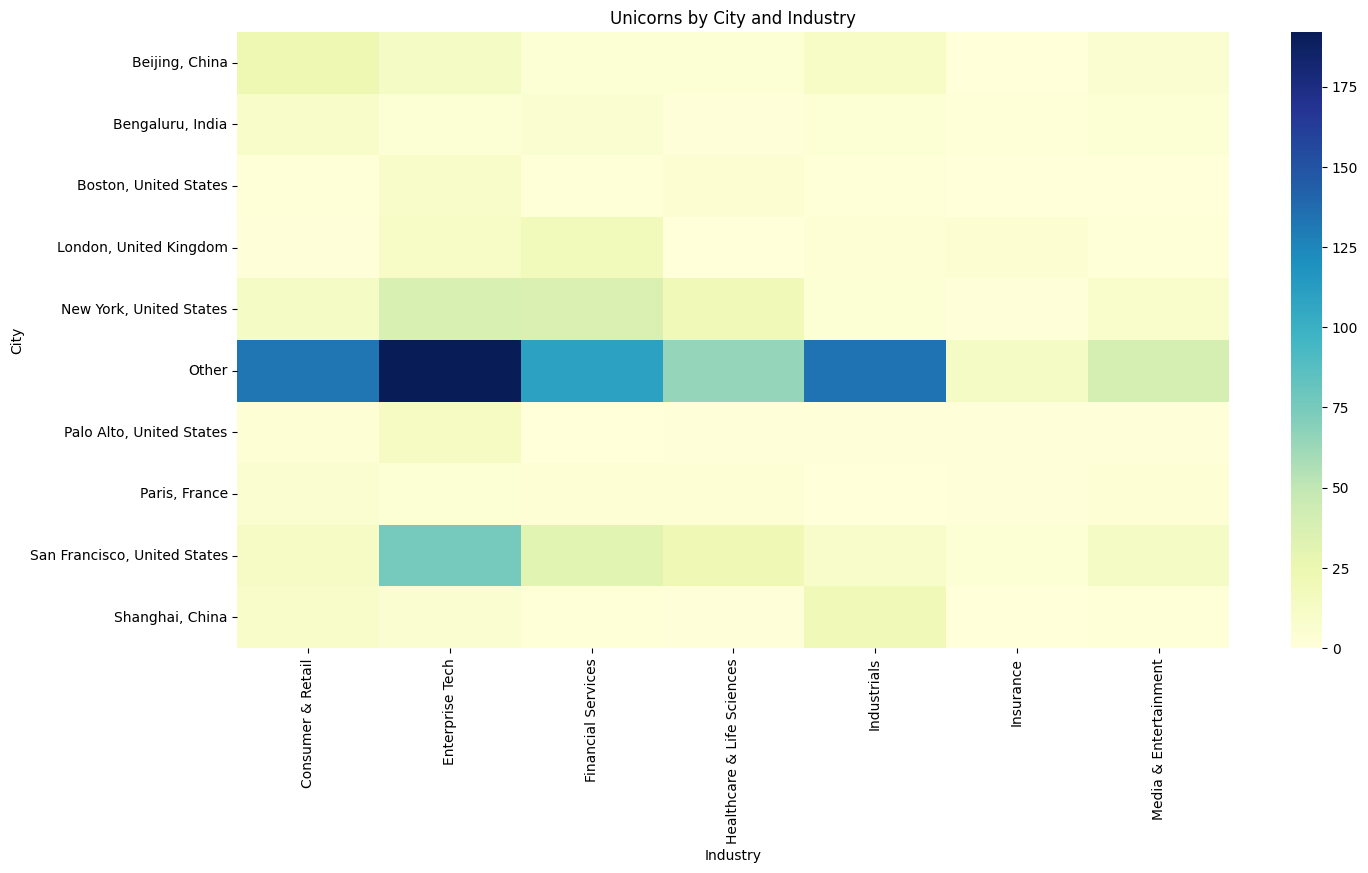

In [55]:
city_industry = pd.crosstab(df['City'], df['Industry'])
plt.figure(figsize=(16,8))
sns.heatmap(city_industry, cmap='YlGnBu')
plt.title('Unicorns by City and Industry')
plt.show()

Conclusion:
- The global unicorn ecosystem is decentralized — with a large number of unicorns emerging outside the top-known tech cities.
- Enterprise Tech and Financial Services are the most popular industries across nearly all cities.
- US cities dominate in total volume, but Bengaluru and Beijing are strong upcoming challengers.
- This reflects a global diversification in innovation, with unicorns rising in non-traditional regions, making the tech economy more inclusive and geographically distributed.

**12. Violin Plot of Valuations by Year Joined**

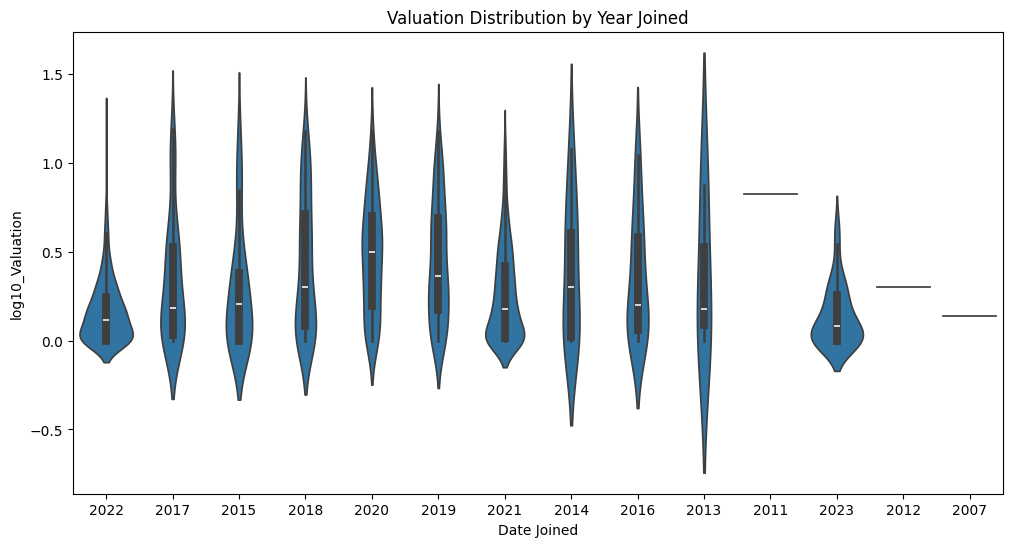

In [57]:
plt.figure(figsize=(12,6))
sns.violinplot(x='Date Joined', y='log10_Valuation', data=df)
plt.title('Valuation Distribution by Year Joined')
plt.show()

Conclusion:
- The unicorn ecosystem experienced its peak diversity in valuations between 2013 and 2016, driven by aggressive funding and large market opportunities.
- Post-2020, valuations are more compressed, indicating a tightening venture capital environment and more cautious investor behavior.
- 2022–2023’s drop in valuation spread suggests a cooling trend in the unicorn market.



**13. Bar Plot: Number of Unicorns per Year**

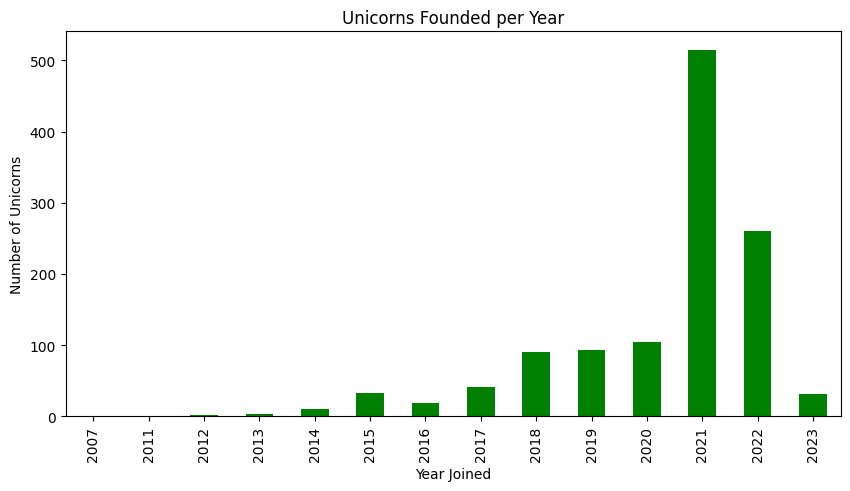

In [58]:
plt.figure(figsize=(10,5))
df['Date Joined'].value_counts().sort_index().plot(kind='bar', color='green')
plt.xlabel('Year Joined')
plt.ylabel('Number of Unicorns')
plt.title('Unicorns Founded per Year')
plt.show()

Conclusion:
- 2021 marked a historic unicorn boom, likely fueled by economic stimulus, digital acceleration, and investor FOMO (fear of missing out).
- The post-2021 decline reveals market correction and valuation rationalization.
- The trend suggests a return to quality and sustainability, where fewer but stronger companies are reaching unicorn status.

**14. Pairplot of Numeric Features**

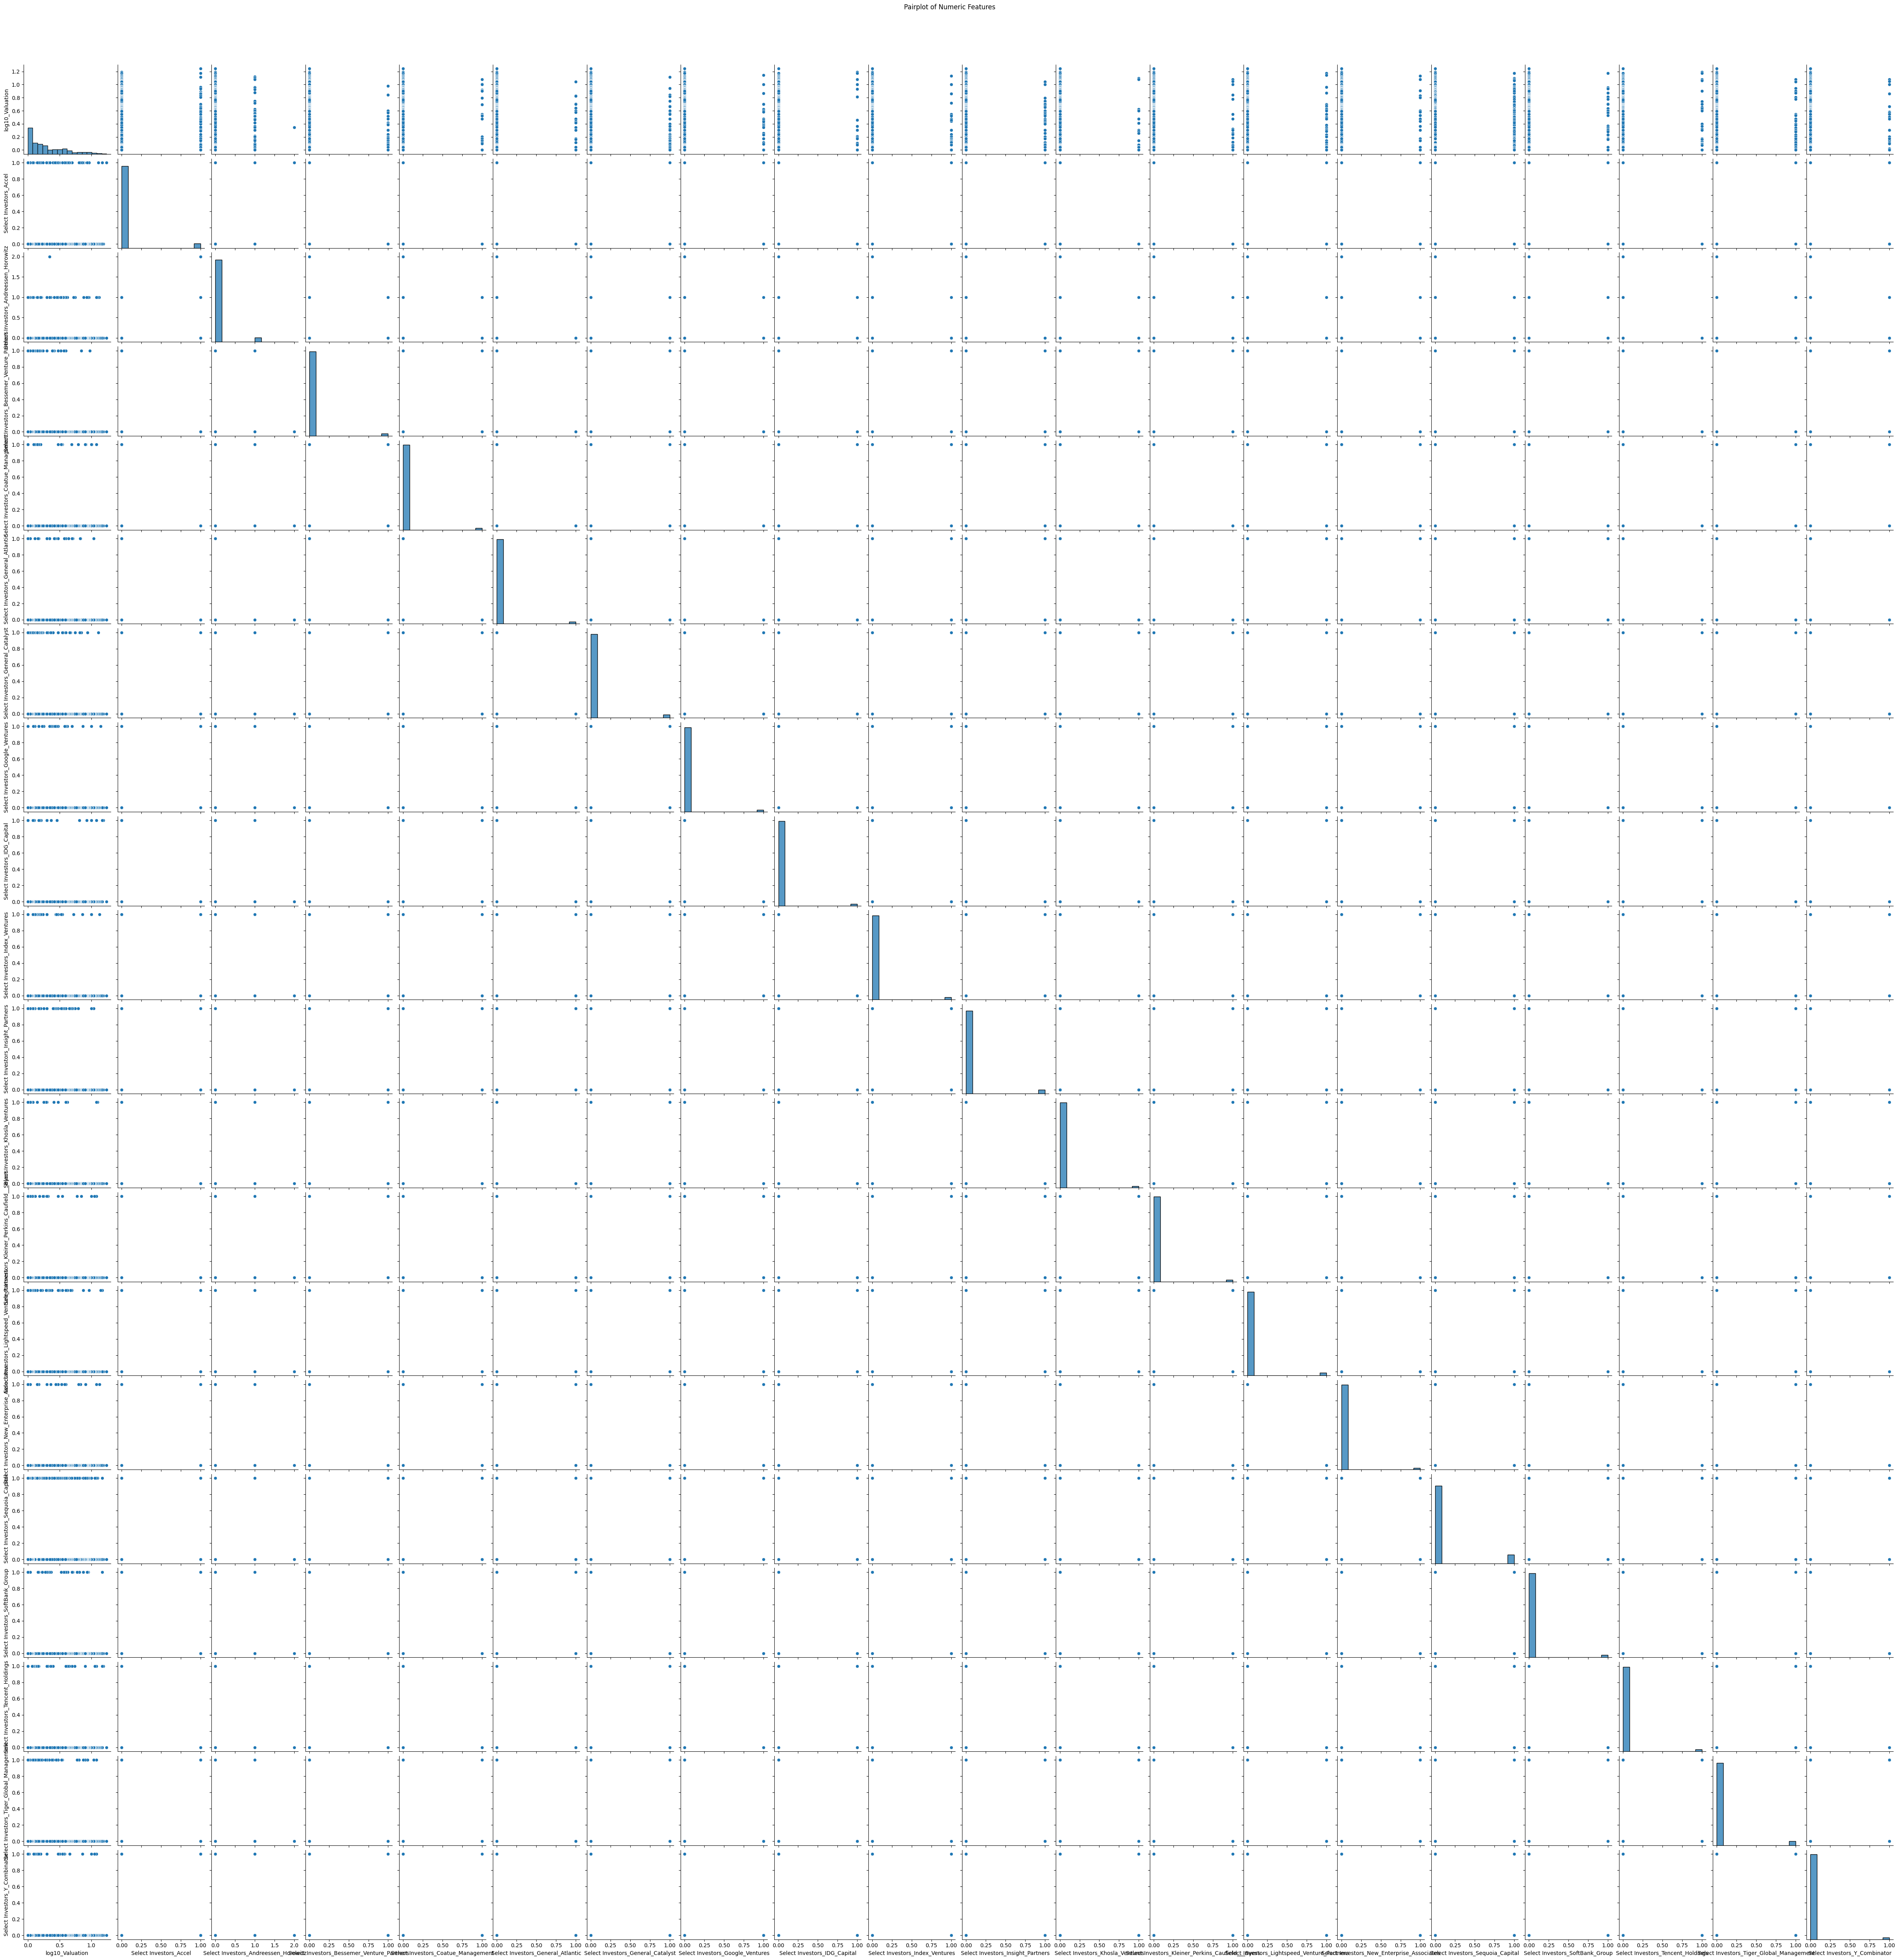

In [59]:
sns.pairplot(df.select_dtypes(include='number'))
plt.suptitle('Pairplot of Numeric Features', y=1.02)
plt.show()

Summary:
- Valuation is strongly linked with total funding and number of investors/rounds — financial growth fuels company value.
- Certain clusters and patterns suggest sectoral or regional behaviors.
- Outliers must be handled or segmented separately for accurate modeling.
- Not all features are linearly related — some may require non-linear or categorical modeling.

**15. Treemap of Unicorns by Industry**

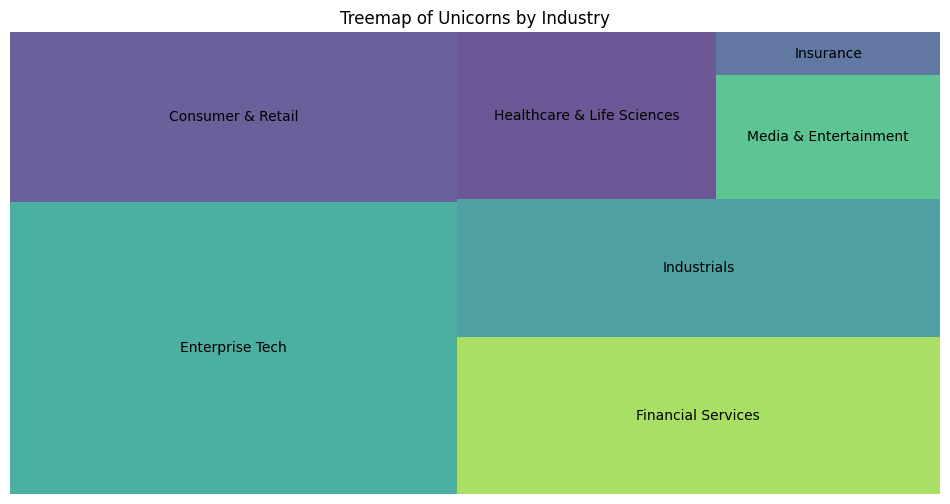

In [60]:
import squarify
industry_counts = df['Industry'].value_counts()
plt.figure(figsize=(12,6))
squarify.plot(sizes=industry_counts.values, label=industry_counts.index, alpha=.8)
plt.title('Treemap of Unicorns by Industry')
plt.axis('off')
plt.show()

Summary:
- Unicorn companies are most concentrated in Enterprise Tech, Consumer & Retail, and Financial Services — reflecting where innovation and funding have been most active.
- Health and Media sectors are promising verticals, while Insurance and Industrials may represent niche disruptors or longer-term plays.
- This distribution reflects both market demand trends and venture capital focus in recent years.



**16. Line Plot: Average Valuation Trend Over Years**

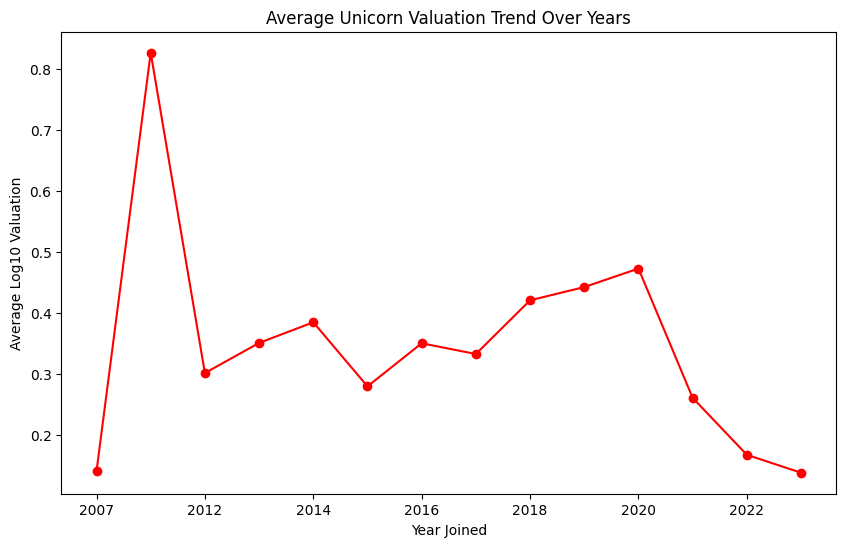

In [61]:
avg_val_by_year = df.groupby('Date Joined')['log10_Valuation'].mean()
plt.figure(figsize=(10,6))
avg_val_by_year.plot(kind='line', marker='o', color='red')
plt.xlabel('Year Joined')
plt.ylabel('Average Log10 Valuation')
plt.title('Average Unicorn Valuation Trend Over Years')
plt.show()

Summary:
- The valuation peak in 2011 and growth till 2020 reflect golden years for unicorn funding.
- The post-2020 dip suggests a more cautious investment environment, focusing on sustainable business models over inflated valuations.

Thank you so much for giving you precious time. I look forward to hearing your thoughts. Please feel free to share any feedback










**Regards,**

**Deepak Mishra**

**Email:** official.deemis@outlook.com